In [1]:
import os
import copy
import pickle
import sympy
import functools
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from error_injection import MissingValueError, SamplingError, Injector
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.metrics import mutual_info_score, auc, roc_curve, roc_auc_score, f1_score
from scipy.optimize import minimize as scipy_min
from scipy.spatial import ConvexHull
from scipy.optimize import minimize, Bounds, linprog
from sympy import Symbol as sb
from sympy import lambdify
from tqdm.notebook import trange,tqdm
from IPython.display import display,clear_output
from random import choice
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

class style():
    RED = '\033[31m'
    GREEN = '\033[32m'
    BLUE = '\033[34m'
    RESET = '\033[0m'

np.random.seed(1)

# ignore all the warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
def load_ins():
    # fetch dataset
    auto_mpg = pd.read_csv('insurance.csv').drop('sex', axis=1).drop('smoker', axis=1).drop('region', axis=1).replace('?', np.nan)
    features = ['age', 'bmi', 'children']
    X = auto_mpg[features].astype(float)
    y = auto_mpg['charges']
    
    # with this random seed, no null value is included in the test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    X_train = copy.deepcopy(X_train).reset_index(drop=True)
    X_test = copy.deepcopy(X_test).reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    return X_train, X_test, y_train, y_test


# first impute the data and make it hypothetically clean
def load_ins_cleaned():
    # fetch dataset
    auto_mpg = pd.read_csv('insurance.csv').drop('sex', axis=1).drop('smoker', axis=1).drop('region', axis=1).replace('?', np.nan)
    features = ['age', 'bmi', 'children']
    X = auto_mpg[features].astype(float)
    y = auto_mpg['charges']
    
    # assumed gt imputation
    imputer = KNNImputer(n_neighbors=10)
    X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    X_train = copy.deepcopy(X_train).reset_index(drop=True)
    X_test = copy.deepcopy(X_test).reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    return X_train, X_test, y_train, y_test

In [3]:
X_train, X_test, y_train, y_test = load_ins_cleaned()

## Unique Functions:

In [4]:
#Useful functions
symbol_id = -1
def create_symbol(suffix=''):
    global symbol_id
    symbol_id += 1
    name = f'e{symbol_id}_{suffix}' if suffix else f'e{symbol_id}'
    return sympy.Symbol(name=name)


scaler_symbols = set([sb(f'k{i}') for i in range(X_train.shape[1]+1)])
linearization_dict = dict()
reverse_linearization_dict = dict()

def inject_sensitive_ranges(X, y, uncertain_attr, uncertain_num, boundary_indices, uncertain_radius_pct=None, 
                  uncertain_radius=None, seed=42):
    global symbol_id
    symbol_id = -1
    
    X_extended = np.append(np.ones((len(X), 1)), X, axis=1)
    ss = StandardScaler()
    X_extended[:, 1:] = ss.fit_transform(X_extended[:, 1:])
    X_extended_symb = sympy.Matrix(X_extended)
    
    if not(uncertain_attr=='y'):
        uncertain_attr_idx = X.columns.to_list().index(uncertain_attr) + 1
        if not(uncertain_radius):
            uncertain_radius = uncertain_radius_pct*(np.max(X_extended[:, uncertain_attr_idx])-\
                                                     np.min(X_extended[:, uncertain_attr_idx]))
    else:
        if not(uncertain_radius):
            uncertain_radius = uncertain_radius_pct*(y_train.max()-y_train.min())[0]
    
    np.random.seed(seed)
    uncertain_indices = boundary_indices[:uncertain_num]
    y_symb = sympy.Matrix(y)
    symbols_in_data = set()
    #print(uncertain_indices)
    for uncertain_idx in uncertain_indices:
        new_symb = create_symbol()
        symbols_in_data.add(new_symb)
        if uncertain_attr=='y':
            y_symb[uncertain_idx] = y_symb[uncertain_idx] + uncertain_radius*new_symb
        else:
            X_extended_symb[uncertain_idx, uncertain_attr_idx] = X_extended_symb[uncertain_idx, uncertain_attr_idx] + uncertain_radius*new_symb
    return X_extended_symb, y_symb, symbols_in_data, ss

# if interval=True, use interval arithmetic, otherwise use zonotopes
def compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, robustness_radius,
                                         uncertain_num, boundary_indices, uncertain_radius=None, 
                                         lr=0.1, seed=42, interval=True):
    X, y, symbols_in_data, ss = inject_sensitive_ranges(X=X_train, y=y_train, uncertain_attr='y', 
                                              uncertain_num=uncertain_num, boundary_indices=boundary_indices, 
                                              uncertain_radius=uncertain_radius, 
                                              uncertain_radius_pct=None, seed=seed)
    
    assert len(X.free_symbols)==0
    # closed-form
    param = (X.T*X).inv()*X.T*y
    
    if interval:
        # make param intervals
        for d in range(len(param)):
            expr = param[d]
            if not(expr.free_symbols):
                continue
            else:
                constant_part = 0
                interval_radius = 0
                for arg in expr.args:
                    if arg.free_symbols:
                        interval_radius += abs(arg.args[0])
                    else:
                        assert constant_part == 0
                        constant_part = arg
                param[d] = constant_part + create_symbol()*interval_radius
    
    test_preds = sympy.Matrix(np.append(np.ones((len(X_test), 1)), ss.transform(X_test), axis=1))*param
    robustness_ls = []
    for pred in test_preds:
        pred_range_radius = 0
        for arg in pred.args:
            if arg.free_symbols:
                pred_range_radius += abs(arg.args[0])
        if pred_range_radius <= robustness_radius:
            robustness_ls.append(1)
        else:
            robustness_ls.append(0)
    
#     print(param)
    return np.mean(robustness_ls)

In [5]:
def identify_extreme_quantiles(y, lower_quantile=0.1, upper_quantile=0.9):
    """
    Identifies indices of `y` values in the extreme quantiles.
    
    """
    lower_threshold = np.quantile(y, lower_quantile)
    upper_threshold = np.quantile(y, upper_quantile)
    
    # Indices where `y` is in the extreme lower or upper quantiles
    extreme_indices = np.where((y <= lower_threshold) | (y >= upper_threshold))[0]
    return extreme_indices

extreme_indices = identify_extreme_quantiles(y_train)

In [6]:
def compute_prediction_variance(X, y, num_models=10):
    """
    Estimates prediction variance for each `y` value using an ensemble of models.

    """
    predictions = []
    
    for i in range(num_models):
        X_resampled, y_resampled = resample(X, y, random_state=i)
        model = LinearRegression().fit(X_resampled, y_resampled)
        predictions.append(model.predict(X))
    
    # Stack predictions and compute standard deviation for each point
    predictions = np.vstack(predictions)
    prediction_std = np.std(predictions, axis=0)
    return prediction_std


X = X_train 
y = y_train
prediction_variance = compute_prediction_variance(X, y)

# Find indices of high-variance predictions (e.g., top 10%)
high_variance_indices = np.argsort(prediction_variance)[-int(0.1 * len(y)):]

In [7]:
combined_indices = np.unique(np.concatenate([extreme_indices, high_variance_indices]))

In [8]:
len(combined_indices)

278

In [9]:
len(X_train) * 10/100

107.0

In [10]:
robustness_dicts = []
for seed in tqdm(range(5), desc=f'Progress'):
    robustness_radius = 500
    label_range = (y_train.max()-y_train.min())
    ratios = [0.02, 0.04, 0.06, 0.08]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict = dict()
    robustness_dict['uncertain_radius'] = uncertain_radiuses
    robustness_dict['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc=f'Rep {seed+1}', leave=False):
        robustness_dict[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius', leave=False):
            robustness_ratio = compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num, 
                                                                    boundary_indices = combined_indices,
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=False, seed=seed)
            robustness_dict[uncertain_pct].append(robustness_ratio)
    robustness_dicts.append(robustness_dict)

Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Rep 1:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Rep 2:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Rep 3:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Rep 4:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Rep 5:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

In [11]:
robustness_dicts_interval = []
for seed in tqdm(range(5), desc=f'Progress'):
    # mpg +- 2 is robust
    robustness_radius = 500
    label_range = (y_train.max()-y_train.min())
    ratios = [0.02, 0.04, 0.06, 0.08]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict_interval = dict()
    robustness_dict_interval['uncertain_radius'] = uncertain_radiuses
    robustness_dict_interval['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc=f'Rep {seed+1}', leave=False):
        robustness_dict_interval[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius', leave=False):
            robustness_ratio = compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num,
                                                                    boundary_indices = combined_indices,
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=True, seed=seed)
            robustness_dict_interval[uncertain_pct].append(robustness_ratio)
    robustness_dicts_interval.append(robustness_dict_interval)

Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Rep 1:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Rep 2:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Rep 3:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Rep 4:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Rep 5:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

In [12]:
robustness_interval_mean = sum([pd.DataFrame(robustness_dicts_interval[i]).iloc[:, 2:] for i in range(5)])/5
robustness_interval_std = (sum([(pd.DataFrame(robustness_dicts_interval[i]).iloc[:, 2:]-robustness_interval_mean)**2 for i in range(5)])/5).apply(np.sqrt)
robustness_zonotope_mean = sum([pd.DataFrame(robustness_dicts[i]).iloc[:, 2:] for i in range(5)])/5
robustness_zonotope_std = (sum([(pd.DataFrame(robustness_dicts[i]).iloc[:, 2:]-robustness_zonotope_mean)**2 for i in range(5)])/5).apply(np.sqrt)

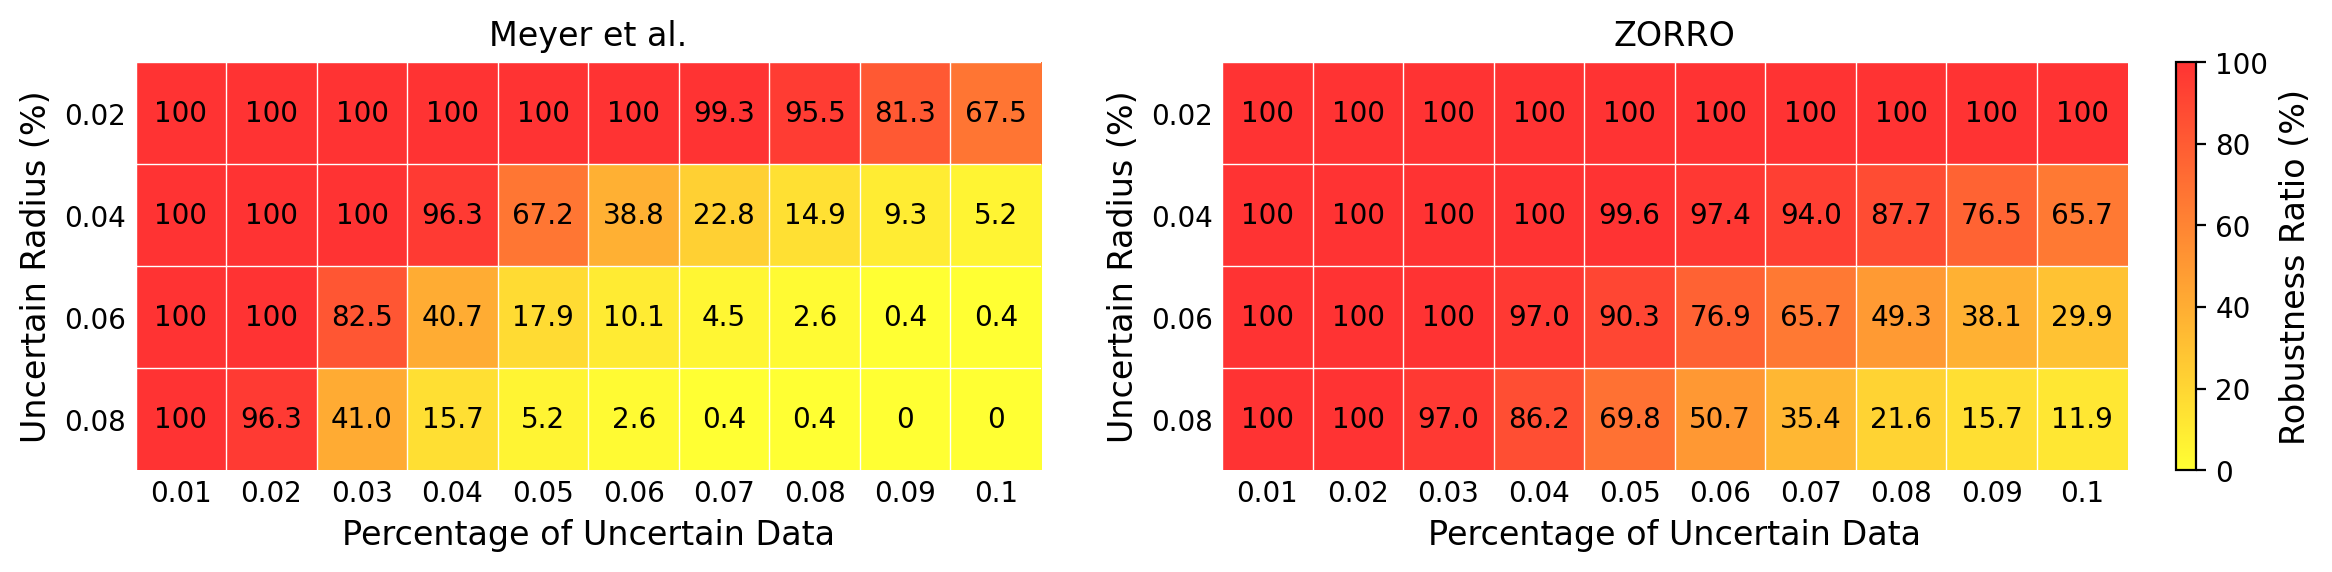

In [13]:
# Heatmaps
df = robustness_interval_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages

# Labels for x-axis and y-axis
x_labels = df.columns.tolist()
y_labels = [0.02, 0.04, 0.06, 0.08]

# Create the heatmap plot
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True, dpi=200)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3), dpi=200)
# cmap = plt.get_cmap("coolwarm")
cmap = plt.get_cmap("autumn_r")
heatmap = ax1.imshow(heatmap_data, cmap=cmap, interpolation='nearest', aspect='auto', 
                     alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar = plt.colorbar(heatmap, ax=ax1)
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax1.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax1.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax1.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax1.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax1.set_xticks(np.arange(len(x_labels)))
ax1.set_yticks(np.arange(len(y_labels)))
ax1.set_xticklabels(x_labels)
ax1.set_yticklabels(y_labels)
ax1.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

# Set axis labels
ax1.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax1.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.0f}', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax1.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.1f}', ha='center', va='center', color='black')
ax1.set_title('Meyer et al.')

df = robustness_zonotope_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages
heatmap2 = ax2.imshow(heatmap_data, cmap=cmap, interpolation='nearest', 
                      aspect='auto', alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax2.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax2.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax2.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax2.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax2.set_xticks(np.arange(len(x_labels)))
ax2.set_yticks(np.arange(len(y_labels)))
ax2.set_xticklabels(x_labels)
ax2.set_yticklabels(y_labels)
ax2.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

# Set axis labels
ax2.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax2.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax2.text(j, i, '100', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax2.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax2.text(j, i, f'{np.around(heatmap_data[i][j], 1)}', ha='center', 
                            va='center', color='black')
ax2.set_title('ZORRO')

# fig.suptitle('Robustness Ratio (%)', fontsize=14)
plt.subplots_adjust(wspace=0.2, bottom=0.2, left=0.1, right=0.9)
cb = fig.colorbar(heatmap2, ax=(ax1, ax2), orientation='vertical', pad=0.02)
cb.set_label('Robustness Ratio (%)', fontsize=12)
plt.savefig('ins-sensitive-heatmap.pdf', bbox_inches='tight')

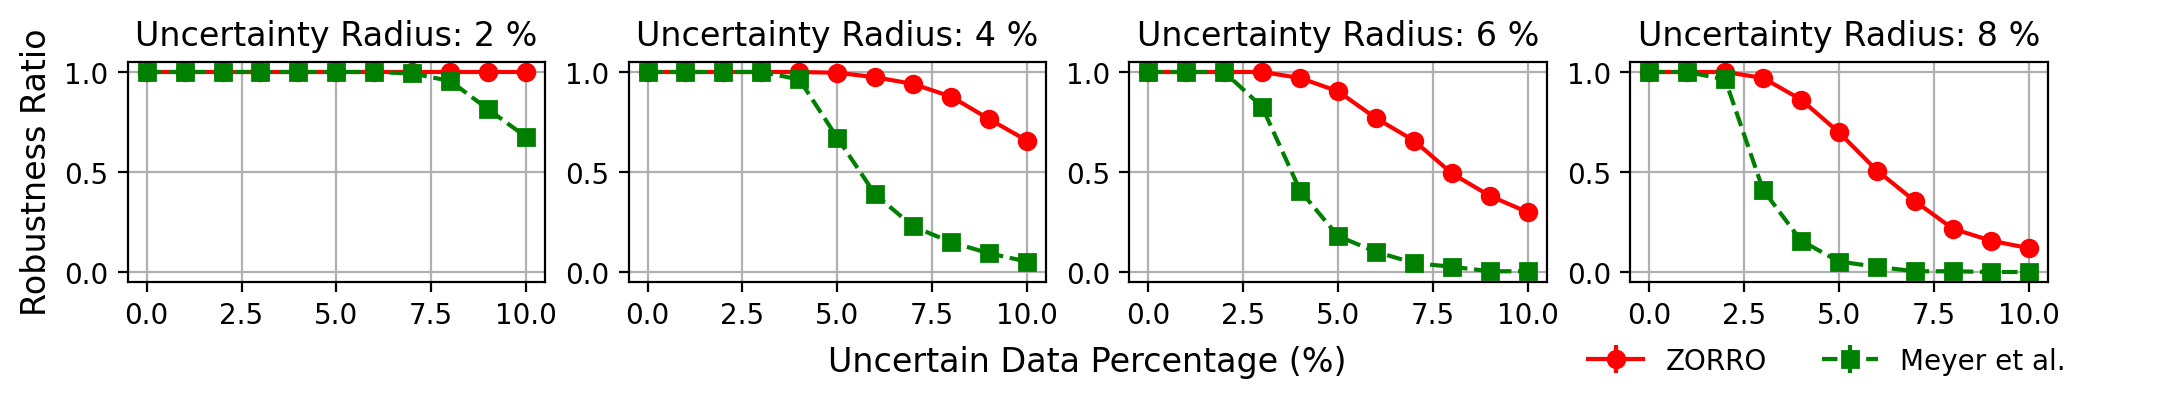

In [14]:
uncertain_pcts = np.array([0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])*100
uncertain_radius_ratios = [0.02, 0.04, 0.06, 0.08]

zonotope_data_mean_dict = dict()
zonotope_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    zonotope_data_mean_dict[radius_ratio] = np.append([1], robustness_zonotope_mean.iloc[i, :].to_numpy())
    zonotope_data_std_dict[radius_ratio] = np.append([0], robustness_zonotope_std.iloc[i, :].to_numpy())

interval_data_mean_dict = dict()
interval_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    interval_data_mean_dict[radius_ratio] = np.append([1], robustness_interval_mean.iloc[i, :].to_numpy())
    interval_data_std_dict[radius_ratio] = np.append([0], robustness_interval_std.iloc[i, :].to_numpy())
    
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 2), sharex=True, dpi=200)

for i in range(4):
    uncertain_radius_ratio = uncertain_radius_ratios[i]
    axes[i].errorbar(uncertain_pcts, zonotope_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*zonotope_data_std_dict[uncertain_radius_ratio],
                     marker='o', color='red', label='ZORRO', linestyle='-')
    axes[i].errorbar(uncertain_pcts, interval_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*interval_data_std_dict[uncertain_radius_ratio],
                     marker='s', color='green', label='Meyer et al.', linestyle='--')
    axes[i].set_title(f'Uncertainty Radius: {int(uncertain_radius_ratio*100)} %')
    if i == 0:
        axes[i].set_ylabel('Robustness Ratio', fontsize=12)
    axes[i].set_ylim(-0.05, 1.05)
    axes[i].grid(True)

# Adjust layout
lines_labels = [axes[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc = (0.73, 0.03), ncol=2, frameon=False)

plt.subplots_adjust(wspace=0.2, top=0.8, bottom=0.25, left=0.1, right=0.9)
fig.supxlabel('Uncertain Data Percentage (%)', fontsize=12, verticalalignment='bottom')
# plt.tight_layout()
# plt.show()
plt.savefig('ins-sensitive-labels-lineplot.pdf', bbox_inches='tight')

In [5]:
#accuracy r2 = True; rmse, mse = False for maximize
def leave_one_out(X_train, y_train, X_test, y_test, model, metric, maximize=True): 
    predictions = model.fit(X_train, y_train).predict(X_test)
    initial_metric = metric(y_test.to_numpy(), predictions)
    influence_results = []
   
    for i in range(len(X_train)):
        X_train_new = np.delete(X_train, i, axis=0)
        y_train_new = np.delete(y_train, i, axis=0)
       
        model_clone = model.__class__(**model.get_params())
        new_preds = model_clone.fit(X_train_new, y_train_new).predict(X_test)
        new_metric = metric(y_test.to_numpy(), new_preds)
       
        metric_diff = (initial_metric - new_metric) if maximize else (new_metric - initial_metric)
        
        influence_results.append((i, metric_diff))
       
       
   
    influence_results = sorted(influence_results,key=lambda x: x[1], reverse=True)
    #print(influence_results)
    return [i[0] for i in influence_results]

def mae(y_true, y_pred):
    return sum(abs(y_true - y_pred))/len(y_true)

def mse(y_true, y_pred):
    return sum((y_true - y_pred)**2)/len(y_true)

def r_squared(y_true, y_pred):
    y_bar = np.mean(y_true)
    return 1 -(sum((y_true - y_pred)**2)/sum((y_true-y_bar)**2))

def rmse(y_true, y_pred):
    return np.sqrt(sum((y_true - y_pred)**2)/len(y_true))

In [16]:
#Using mae, randomforest:
rf = RandomForestRegressor()
X_train, X_test, y_train, y_test = X_train.reset_index(drop=True) , X_test.reset_index(drop=True) , y_train.reset_index(drop=True) , y_test.reset_index(drop=True)
boundary_indices = leave_one_out(X_train, y_train, X_test, y_test, rf, mae, maximize=False)
boundary_indices 

[227,
 38,
 999,
 931,
 539,
 595,
 329,
 825,
 680,
 25,
 734,
 601,
 566,
 528,
 1043,
 462,
 1057,
 49,
 512,
 291,
 345,
 503,
 919,
 1023,
 270,
 246,
 1005,
 578,
 780,
 955,
 784,
 446,
 179,
 730,
 395,
 772,
 988,
 73,
 523,
 426,
 1069,
 50,
 479,
 500,
 1056,
 790,
 226,
 444,
 53,
 524,
 819,
 175,
 1046,
 230,
 164,
 986,
 910,
 515,
 5,
 552,
 558,
 907,
 92,
 573,
 211,
 367,
 550,
 637,
 243,
 952,
 1041,
 402,
 42,
 338,
 553,
 983,
 724,
 658,
 756,
 799,
 433,
 736,
 85,
 1018,
 918,
 178,
 949,
 820,
 156,
 189,
 116,
 929,
 122,
 521,
 911,
 530,
 381,
 111,
 1060,
 802,
 994,
 244,
 138,
 618,
 737,
 26,
 484,
 934,
 410,
 625,
 794,
 279,
 655,
 513,
 782,
 29,
 255,
 1008,
 272,
 827,
 942,
 741,
 438,
 850,
 667,
 717,
 577,
 358,
 34,
 4,
 763,
 690,
 389,
 392,
 135,
 420,
 448,
 801,
 1042,
 166,
 647,
 902,
 958,
 669,
 78,
 862,
 876,
 131,
 851,
 779,
 947,
 516,
 562,
 623,
 975,
 874,
 387,
 956,
 377,
 1021,
 333,
 665,
 531,
 917,
 100,
 418,
 1032,
 

In [17]:
robustness_dicts = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 2
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict = dict()
    robustness_dict['uncertain_radius'] = uncertain_radiuses
    robustness_dict['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_dict[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius'):
            #print(uncertain_radius)
            robustness_ratio = compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num,
                                                                    boundary_indices=boundary_indices,
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=False, seed=seed)
            robustness_dict[uncertain_pct].append(robustness_ratio)
    robustness_dicts.append(robustness_dict)

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

In [18]:
robustness_dicts_interval = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 2
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict_interval = dict()
    robustness_dict_interval['uncertain_radius'] = uncertain_radiuses
    robustness_dict_interval['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_dict_interval[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius'):
            robustness_ratio = compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num,
                                                                    boundary_indices=boundary_indices,
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=True, seed=seed)
            robustness_dict_interval[uncertain_pct].append(robustness_ratio)
    robustness_dicts_interval.append(robustness_dict_interval)

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

In [19]:
robustness_interval_mean = sum([pd.DataFrame(robustness_dicts_interval[i]).iloc[:, 2:] for i in range(5)])/5
robustness_interval_std = (sum([(pd.DataFrame(robustness_dicts_interval[i]).iloc[:, 2:]-robustness_interval_mean)**2 for i in range(5)])/5).apply(np.sqrt)
robustness_zonotope_mean = sum([pd.DataFrame(robustness_dicts[i]).iloc[:, 2:] for i in range(5)])/5
robustness_zonotope_std = (sum([(pd.DataFrame(robustness_dicts[i]).iloc[:, 2:]-robustness_zonotope_mean)**2 for i in range(5)])/5).apply(np.sqrt)


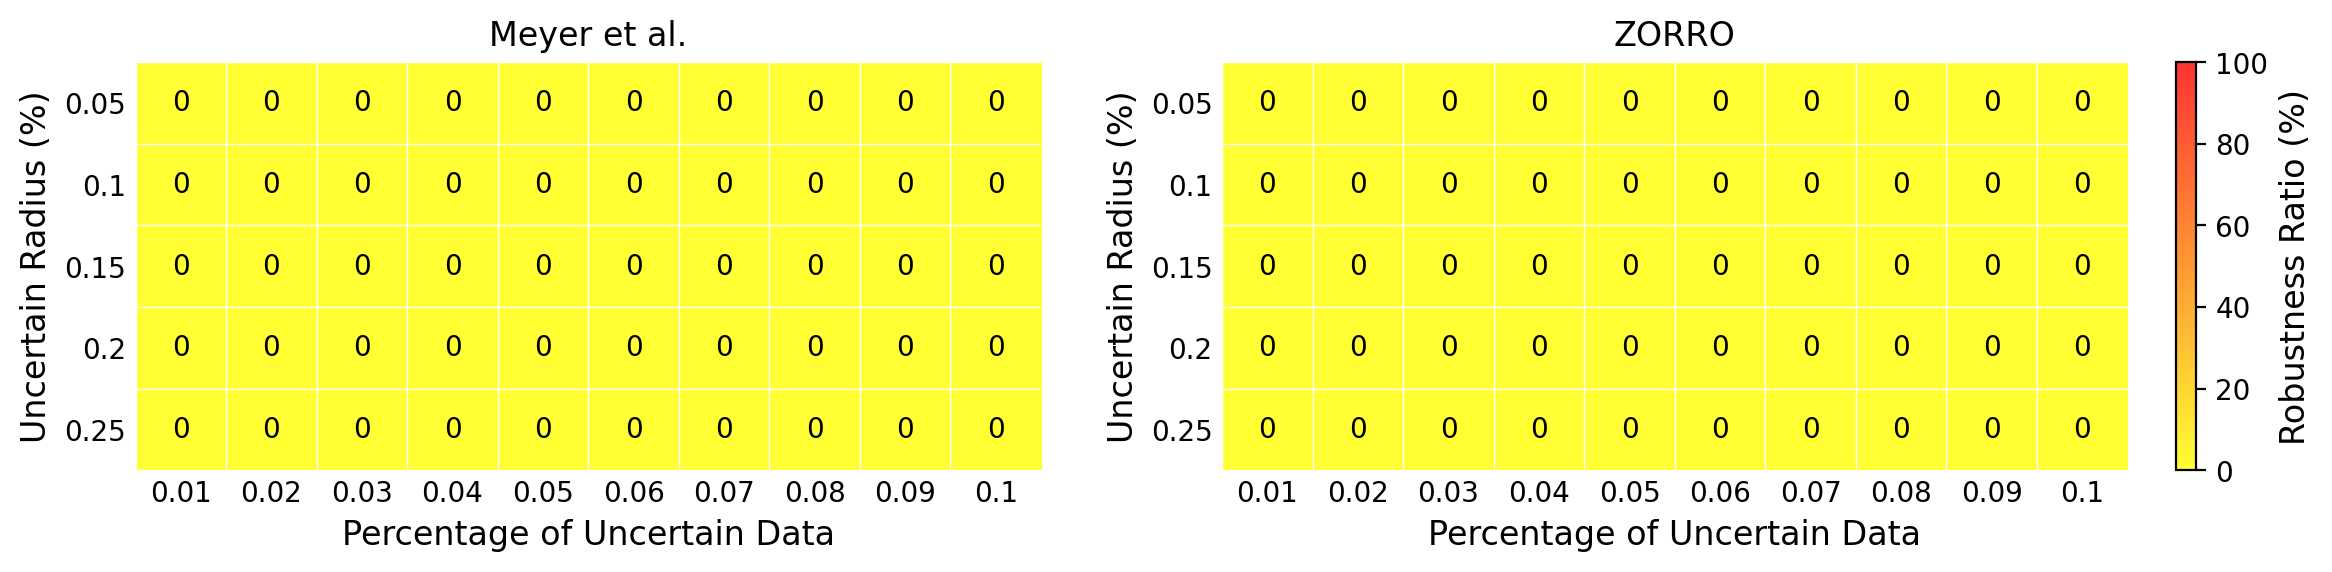

In [20]:
# Heatmaps
df = robustness_interval_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages

# Labels for x-axis and y-axis
x_labels = df.columns.tolist()
y_labels = [0.05, 0.10, 0.15, 0.2, 0.25]

# Create the heatmap plot
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True, dpi=200)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3), dpi=200)
# cmap = plt.get_cmap("coolwarm")
cmap = plt.get_cmap("autumn_r")
heatmap = ax1.imshow(heatmap_data, cmap=cmap, interpolation='nearest', aspect='auto', 
                     alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar = plt.colorbar(heatmap, ax=ax1)
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax1.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax1.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax1.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax1.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax1.set_xticks(np.arange(len(x_labels)))
ax1.set_yticks(np.arange(len(y_labels)))
ax1.set_xticklabels(x_labels)
ax1.set_yticklabels(y_labels)
ax1.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

# Set axis labels
ax1.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax1.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.0f}', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax1.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.1f}', ha='center', va='center', color='black')
ax1.set_title('Meyer et al.')

df = robustness_zonotope_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages
heatmap2 = ax2.imshow(heatmap_data, cmap=cmap, interpolation='nearest', 
                      aspect='auto', alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax2.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax2.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax2.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax2.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax2.set_xticks(np.arange(len(x_labels)))
ax2.set_yticks(np.arange(len(y_labels)))
ax2.set_xticklabels(x_labels)
ax2.set_yticklabels(y_labels)
ax2.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

# Set axis labels
ax2.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax2.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax2.text(j, i, '100', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax2.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax2.text(j, i, f'{np.around(heatmap_data[i][j], 1)}', ha='center', 
                            va='center', color='black')
ax2.set_title('ZORRO')

# fig.suptitle('Robustness Ratio (%)', fontsize=14)
plt.subplots_adjust(wspace=0.2, bottom=0.2, left=0.1, right=0.9)
cb = fig.colorbar(heatmap2, ax=(ax1, ax2), orientation='vertical', pad=0.02)
cb.set_label('Robustness Ratio (%)', fontsize=12)
plt.savefig('ins-randomForest-mae-sensitive-heatmap.pdf', bbox_inches='tight')

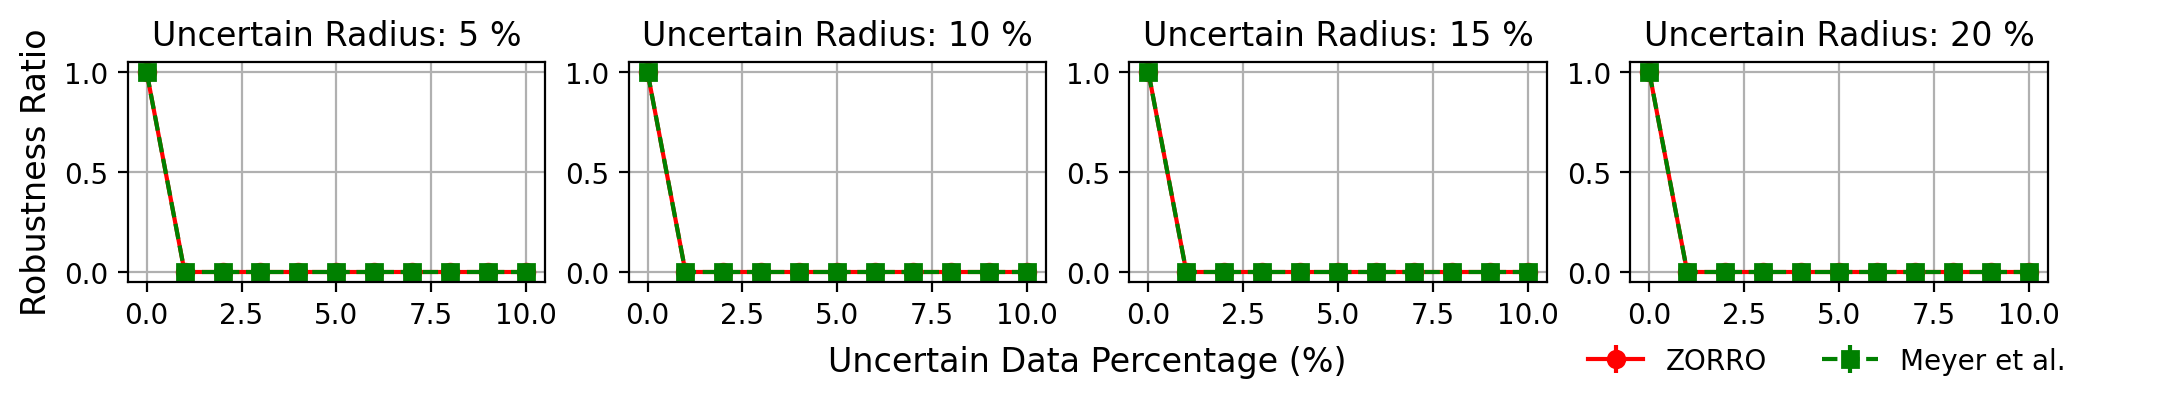

In [21]:
uncertain_pcts = np.array([0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])*100
uncertain_radius_ratios = [0.05, 0.10, 0.15, 0.2, 0.25]

zonotope_data_mean_dict = dict()
zonotope_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    zonotope_data_mean_dict[radius_ratio] = np.append([1], robustness_zonotope_mean.iloc[i, :].to_numpy())
    zonotope_data_std_dict[radius_ratio] = np.append([0], robustness_zonotope_std.iloc[i, :].to_numpy())

interval_data_mean_dict = dict()
interval_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    interval_data_mean_dict[radius_ratio] = np.append([1], robustness_interval_mean.iloc[i, :].to_numpy())
    interval_data_std_dict[radius_ratio] = np.append([0], robustness_interval_std.iloc[i, :].to_numpy())
    
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 2), sharex=True, dpi=200)

for i in range(4):
    uncertain_radius_ratio = uncertain_radius_ratios[i]
    axes[i].errorbar(uncertain_pcts, zonotope_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*zonotope_data_std_dict[uncertain_radius_ratio],
                     marker='o', color='red', label='ZORRO', linestyle='-')
    axes[i].errorbar(uncertain_pcts, interval_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*interval_data_std_dict[uncertain_radius_ratio],
                     marker='s', color='green', label='Meyer et al.', linestyle='--')
    axes[i].set_title(f'Uncertain Radius: {int(uncertain_radius_ratio*100)} %')
    if i == 0:
        axes[i].set_ylabel('Robustness Ratio', fontsize=12)
    axes[i].set_ylim(-0.05, 1.05)
    axes[i].grid(True)

# Adjust layout
lines_labels = [axes[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc = (0.73, 0.03), ncol=2, frameon=False)

plt.subplots_adjust(wspace=0.2, top=0.8, bottom=0.25, left=0.1, right=0.9)
fig.supxlabel('Uncertain Data Percentage (%)', fontsize=12, verticalalignment='bottom')
# plt.tight_layout()
# plt.show()
plt.savefig('ins-randomForest-mae-sensitive-labels-lineplot.pdf', bbox_inches='tight')

In [22]:
#Using mae, LinearRegression
lr = LinearRegression()
X_train, X_test, y_train, y_test = X_train.reset_index(drop=True) , X_test.reset_index(drop=True) , y_train.reset_index(drop=True) , y_test.reset_index(drop=True)
boundary_indices = leave_one_out(X_train, y_train, X_test, y_test, lr, mae, maximize=False)
boundary_indices 

[556,
 118,
 103,
 550,
 866,
 861,
 405,
 833,
 955,
 739,
 713,
 875,
 431,
 153,
 69,
 229,
 63,
 129,
 24,
 635,
 239,
 1009,
 764,
 1011,
 495,
 357,
 413,
 52,
 146,
 1026,
 974,
 1022,
 907,
 81,
 869,
 825,
 979,
 753,
 769,
 1000,
 485,
 256,
 267,
 104,
 1010,
 744,
 528,
 432,
 525,
 177,
 617,
 673,
 719,
 819,
 754,
 589,
 1036,
 290,
 522,
 332,
 1017,
 977,
 391,
 341,
 816,
 752,
 1028,
 47,
 443,
 675,
 945,
 570,
 694,
 766,
 1016,
 932,
 805,
 881,
 503,
 601,
 246,
 702,
 640,
 351,
 169,
 138,
 88,
 873,
 481,
 46,
 243,
 954,
 912,
 747,
 552,
 28,
 476,
 670,
 202,
 22,
 208,
 599,
 902,
 232,
 953,
 312,
 718,
 494,
 25,
 348,
 612,
 170,
 745,
 920,
 156,
 765,
 331,
 478,
 532,
 144,
 427,
 1065,
 962,
 230,
 961,
 111,
 509,
 306,
 668,
 511,
 460,
 497,
 465,
 4,
 998,
 336,
 292,
 882,
 654,
 307,
 220,
 969,
 45,
 134,
 50,
 289,
 368,
 725,
 211,
 609,
 1047,
 914,
 644,
 172,
 390,
 691,
 1035,
 433,
 854,
 637,
 643,
 147,
 456,
 396,
 684,
 1060,
 667,

In [23]:
robustness_dicts = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 2
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict = dict()
    robustness_dict['uncertain_radius'] = uncertain_radiuses
    robustness_dict['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_dict[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius'):
            #print(uncertain_radius)
            robustness_ratio = compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num,
                                                                    boundary_indices=boundary_indices,
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=False, seed=seed)
            robustness_dict[uncertain_pct].append(robustness_ratio)
    robustness_dicts.append(robustness_dict)

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

In [24]:
robustness_dicts_interval = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 2
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict_interval = dict()
    robustness_dict_interval['uncertain_radius'] = uncertain_radiuses
    robustness_dict_interval['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_dict_interval[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius'):
            robustness_ratio = compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num,
                                                                    boundary_indices=boundary_indices,
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=True, seed=seed)
            robustness_dict_interval[uncertain_pct].append(robustness_ratio)
    robustness_dicts_interval.append(robustness_dict_interval)

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

In [25]:
robustness_interval_mean = sum([pd.DataFrame(robustness_dicts_interval[i]).iloc[:, 2:] for i in range(5)])/5
robustness_interval_std = (sum([(pd.DataFrame(robustness_dicts_interval[i]).iloc[:, 2:]-robustness_interval_mean)**2 for i in range(5)])/5).apply(np.sqrt)
robustness_zonotope_mean = sum([pd.DataFrame(robustness_dicts[i]).iloc[:, 2:] for i in range(5)])/5
robustness_zonotope_std = (sum([(pd.DataFrame(robustness_dicts[i]).iloc[:, 2:]-robustness_zonotope_mean)**2 for i in range(5)])/5).apply(np.sqrt)


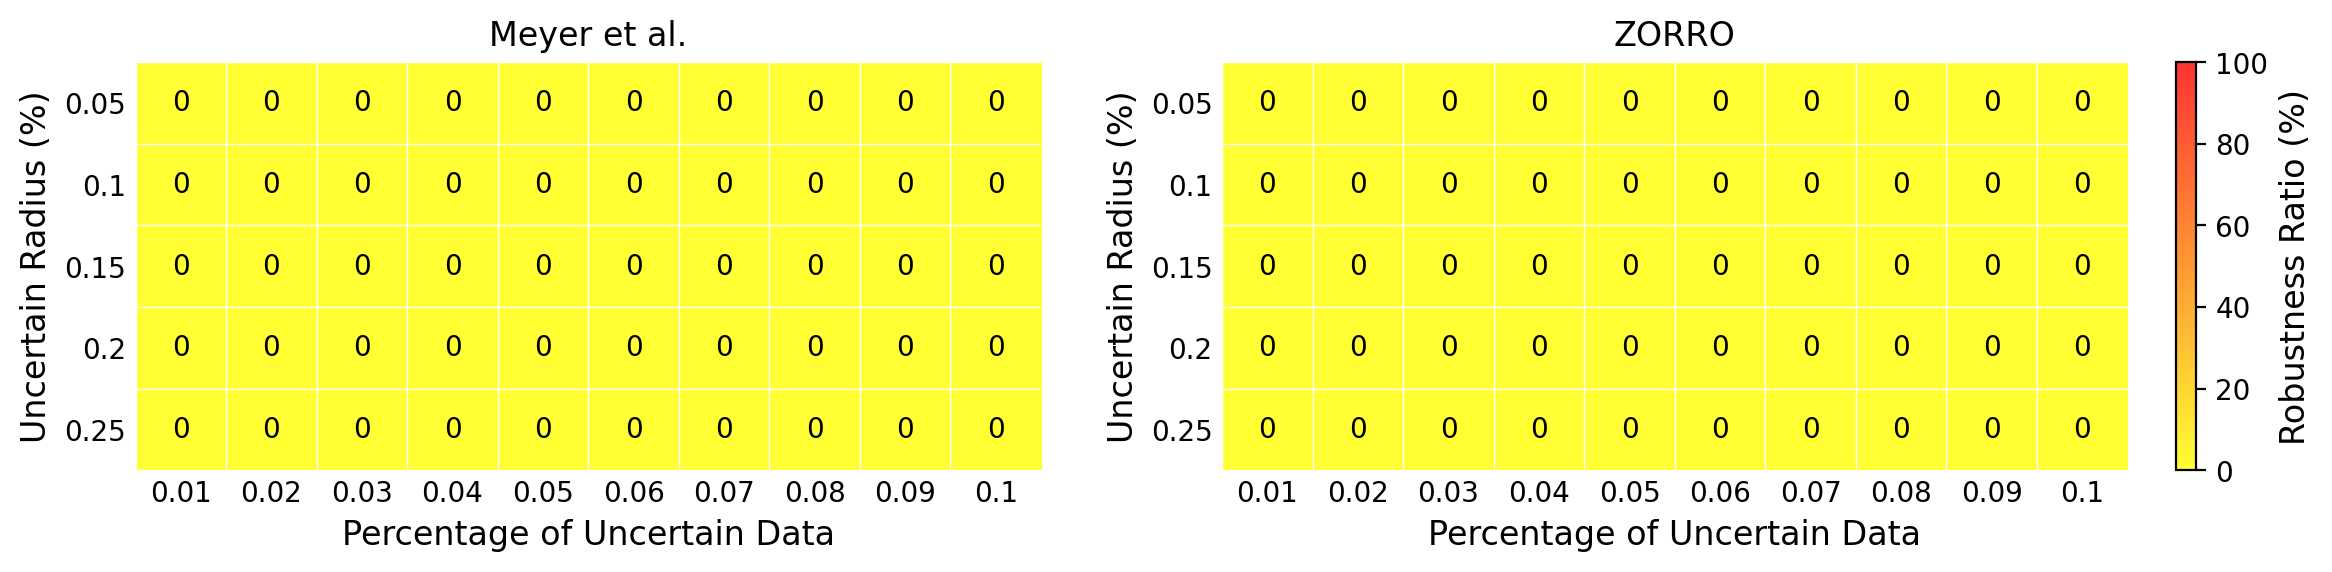

In [26]:
# Heatmaps
df = robustness_interval_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages

# Labels for x-axis and y-axis
x_labels = df.columns.tolist()
y_labels = [0.05, 0.10, 0.15, 0.2, 0.25]

# Create the heatmap plot
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True, dpi=200)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3), dpi=200)
# cmap = plt.get_cmap("coolwarm")
cmap = plt.get_cmap("autumn_r")
heatmap = ax1.imshow(heatmap_data, cmap=cmap, interpolation='nearest', aspect='auto', 
                     alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar = plt.colorbar(heatmap, ax=ax1)
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax1.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax1.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax1.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax1.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax1.set_xticks(np.arange(len(x_labels)))
ax1.set_yticks(np.arange(len(y_labels)))
ax1.set_xticklabels(x_labels)
ax1.set_yticklabels(y_labels)
ax1.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

# Set axis labels
ax1.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax1.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.0f}', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax1.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.1f}', ha='center', va='center', color='black')
ax1.set_title('Meyer et al.')

df = robustness_zonotope_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages
heatmap2 = ax2.imshow(heatmap_data, cmap=cmap, interpolation='nearest', 
                      aspect='auto', alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax2.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax2.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax2.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax2.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax2.set_xticks(np.arange(len(x_labels)))
ax2.set_yticks(np.arange(len(y_labels)))
ax2.set_xticklabels(x_labels)
ax2.set_yticklabels(y_labels)
ax2.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

# Set axis labels
ax2.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax2.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax2.text(j, i, '100', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax2.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax2.text(j, i, f'{np.around(heatmap_data[i][j], 1)}', ha='center', 
                            va='center', color='black')
ax2.set_title('ZORRO')

# fig.suptitle('Robustness Ratio (%)', fontsize=14)
plt.subplots_adjust(wspace=0.2, bottom=0.2, left=0.1, right=0.9)
cb = fig.colorbar(heatmap2, ax=(ax1, ax2), orientation='vertical', pad=0.02)
cb.set_label('Robustness Ratio (%)', fontsize=12)
plt.savefig('ins-linear-mae-sensitive-heatmap.pdf', bbox_inches='tight')

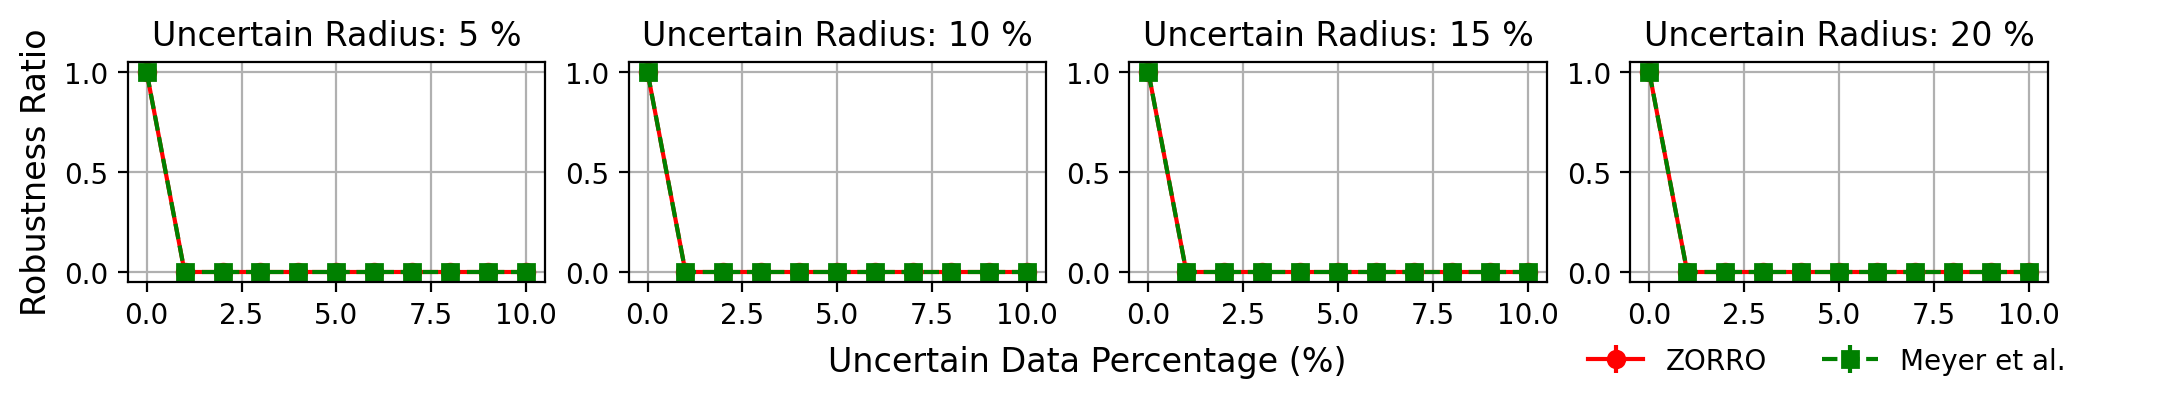

In [27]:
uncertain_pcts = np.array([0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])*100
uncertain_radius_ratios = [0.05, 0.10, 0.15, 0.2, 0.25]

zonotope_data_mean_dict = dict()
zonotope_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    zonotope_data_mean_dict[radius_ratio] = np.append([1], robustness_zonotope_mean.iloc[i, :].to_numpy())
    zonotope_data_std_dict[radius_ratio] = np.append([0], robustness_zonotope_std.iloc[i, :].to_numpy())

interval_data_mean_dict = dict()
interval_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    interval_data_mean_dict[radius_ratio] = np.append([1], robustness_interval_mean.iloc[i, :].to_numpy())
    interval_data_std_dict[radius_ratio] = np.append([0], robustness_interval_std.iloc[i, :].to_numpy())
    
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 2), sharex=True, dpi=200)

for i in range(4):
    uncertain_radius_ratio = uncertain_radius_ratios[i]
    axes[i].errorbar(uncertain_pcts, zonotope_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*zonotope_data_std_dict[uncertain_radius_ratio],
                     marker='o', color='red', label='ZORRO', linestyle='-')
    axes[i].errorbar(uncertain_pcts, interval_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*interval_data_std_dict[uncertain_radius_ratio],
                     marker='s', color='green', label='Meyer et al.', linestyle='--')
    axes[i].set_title(f'Uncertain Radius: {int(uncertain_radius_ratio*100)} %')
    if i == 0:
        axes[i].set_ylabel('Robustness Ratio', fontsize=12)
    axes[i].set_ylim(-0.05, 1.05)
    axes[i].grid(True)

# Adjust layout
lines_labels = [axes[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc = (0.73, 0.03), ncol=2, frameon=False)

plt.subplots_adjust(wspace=0.2, top=0.8, bottom=0.25, left=0.1, right=0.9)
fig.supxlabel('Uncertain Data Percentage (%)', fontsize=12, verticalalignment='bottom')
# plt.tight_layout()
# plt.show()
plt.savefig('ins-linear-mae-sensitive-labels-lineplot.pdf', bbox_inches='tight')

In [11]:
#Using r_squared, LinearRegression
lr = LinearRegression()
X_train, X_test, y_train, y_test = X_train.reset_index(drop=True) , X_test.reset_index(drop=True) , y_train.reset_index(drop=True) , y_test.reset_index(drop=True)
boundary_indices = leave_one_out(X_train, y_train, X_test, y_test, lr, r_squared)
boundary_indices 

[404,
 1020,
 392,
 182,
 196,
 194,
 346,
 1004,
 1019,
 822,
 692,
 273,
 1034,
 545,
 886,
 271,
 860,
 983,
 949,
 811,
 378,
 241,
 394,
 496,
 29,
 581,
 467,
 600,
 123,
 663,
 77,
 425,
 959,
 689,
 285,
 908,
 414,
 98,
 1067,
 115,
 676,
 770,
 508,
 524,
 187,
 1050,
 935,
 927,
 547,
 296,
 611,
 205,
 356,
 915,
 842,
 785,
 555,
 826,
 1062,
 475,
 634,
 738,
 850,
 470,
 380,
 492,
 411,
 85,
 415,
 783,
 326,
 957,
 515,
 823,
 490,
 830,
 506,
 375,
 66,
 484,
 565,
 961,
 509,
 668,
 306,
 546,
 74,
 1025,
 134,
 745,
 403,
 965,
 290,
 497,
 339,
 879,
 819,
 865,
 684,
 557,
 25,
 1065,
 902,
 536,
 517,
 177,
 747,
 224,
 946,
 173,
 755,
 172,
 319,
 502,
 292,
 227,
 433,
 558,
 854,
 22,
 937,
 691,
 837,
 670,
 0,
 1014,
 601,
 331,
 768,
 703,
 88,
 186,
 816,
 430,
 678,
 805,
 487,
 599,
 111,
 46,
 38,
 213,
 249,
 336,
 1036,
 591,
 268,
 215,
 1013,
 520,
 977,
 867,
 246,
 312,
 462,
 437,
 722,
 694,
 426,
 211,
 222,
 766,
 821,
 422,
 519,
 237,
 680,

In [12]:
robustness_dicts = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 2
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict = dict()
    robustness_dict['uncertain_radius'] = uncertain_radiuses
    robustness_dict['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_dict[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius'):
            #print(uncertain_radius)
            robustness_ratio = compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num,
                                                                    boundary_indices=boundary_indices,
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=False, seed=seed)
            robustness_dict[uncertain_pct].append(robustness_ratio)
    robustness_dicts.append(robustness_dict)

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

In [13]:
robustness_dicts_interval = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 2
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict_interval = dict()
    robustness_dict_interval['uncertain_radius'] = uncertain_radiuses
    robustness_dict_interval['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_dict_interval[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius'):
            robustness_ratio = compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num,
                                                                    boundary_indices=boundary_indices,
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=True, seed=seed)
            robustness_dict_interval[uncertain_pct].append(robustness_ratio)
    robustness_dicts_interval.append(robustness_dict_interval)

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

In [14]:
robustness_interval_mean = sum([pd.DataFrame(robustness_dicts_interval[i]).iloc[:, 2:] for i in range(5)])/5
robustness_interval_std = (sum([(pd.DataFrame(robustness_dicts_interval[i]).iloc[:, 2:]-robustness_interval_mean)**2 for i in range(5)])/5).apply(np.sqrt)
robustness_zonotope_mean = sum([pd.DataFrame(robustness_dicts[i]).iloc[:, 2:] for i in range(5)])/5
robustness_zonotope_std = (sum([(pd.DataFrame(robustness_dicts[i]).iloc[:, 2:]-robustness_zonotope_mean)**2 for i in range(5)])/5).apply(np.sqrt)


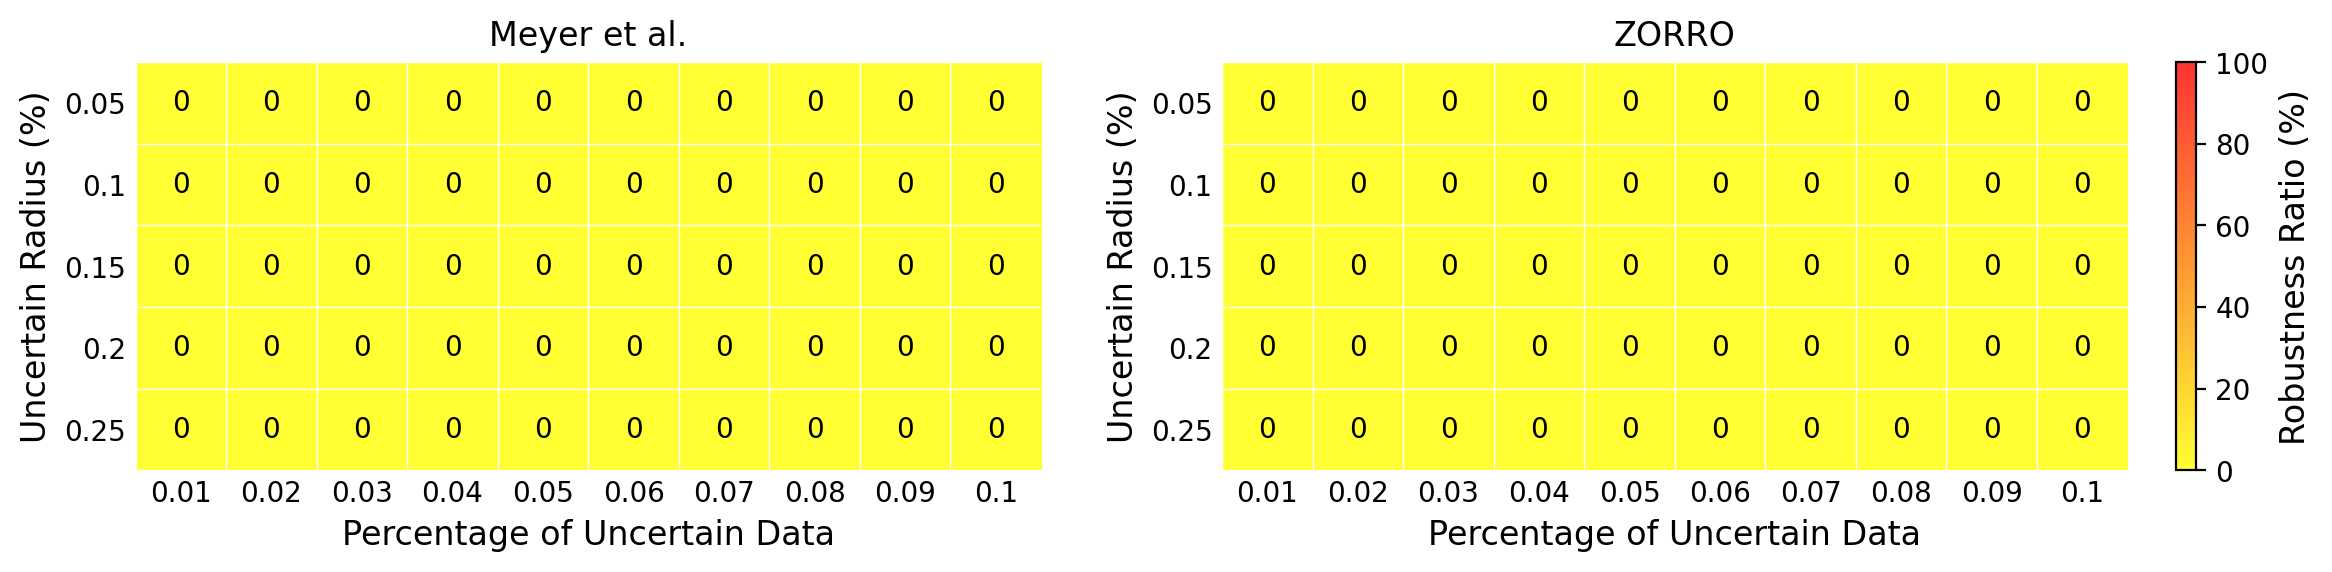

In [15]:
# Heatmaps
df = robustness_interval_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages

# Labels for x-axis and y-axis
x_labels = df.columns.tolist()
y_labels = [0.05, 0.10, 0.15, 0.2, 0.25]

# Create the heatmap plot
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True, dpi=200)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3), dpi=200)
# cmap = plt.get_cmap("coolwarm")
cmap = plt.get_cmap("autumn_r")
heatmap = ax1.imshow(heatmap_data, cmap=cmap, interpolation='nearest', aspect='auto', 
                     alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar = plt.colorbar(heatmap, ax=ax1)
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax1.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax1.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax1.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax1.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax1.set_xticks(np.arange(len(x_labels)))
ax1.set_yticks(np.arange(len(y_labels)))
ax1.set_xticklabels(x_labels)
ax1.set_yticklabels(y_labels)
ax1.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

# Set axis labels
ax1.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax1.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.0f}', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax1.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.1f}', ha='center', va='center', color='black')
ax1.set_title('Meyer et al.')

df = robustness_zonotope_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages
heatmap2 = ax2.imshow(heatmap_data, cmap=cmap, interpolation='nearest', 
                      aspect='auto', alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax2.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax2.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax2.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax2.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax2.set_xticks(np.arange(len(x_labels)))
ax2.set_yticks(np.arange(len(y_labels)))
ax2.set_xticklabels(x_labels)
ax2.set_yticklabels(y_labels)
ax2.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

# Set axis labels
ax2.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax2.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax2.text(j, i, '100', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax2.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax2.text(j, i, f'{np.around(heatmap_data[i][j], 1)}', ha='center', 
                            va='center', color='black')
ax2.set_title('ZORRO')

# fig.suptitle('Robustness Ratio (%)', fontsize=14)
plt.subplots_adjust(wspace=0.2, bottom=0.2, left=0.1, right=0.9)
cb = fig.colorbar(heatmap2, ax=(ax1, ax2), orientation='vertical', pad=0.02)
cb.set_label('Robustness Ratio (%)', fontsize=12)
plt.savefig('ins-linear-r-squared-sensitive-heatmap.pdf', bbox_inches='tight')

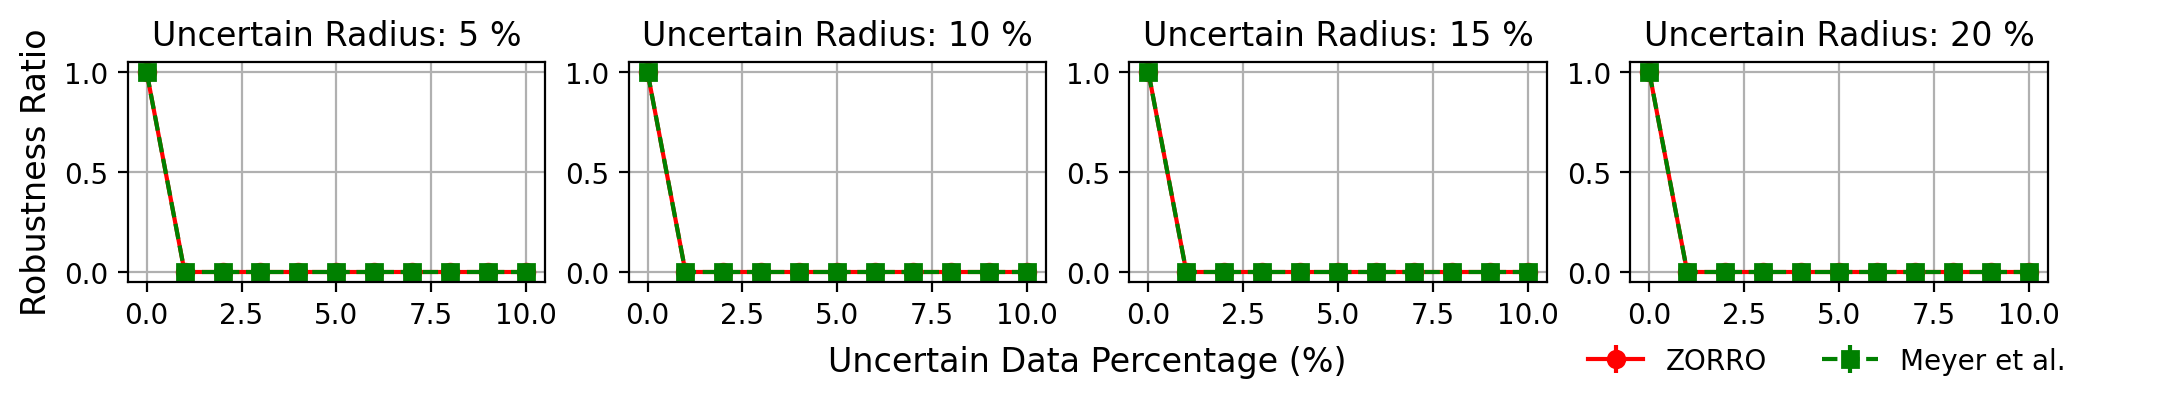

In [16]:
uncertain_pcts = np.array([0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])*100
uncertain_radius_ratios = [0.05, 0.10, 0.15, 0.2, 0.25]

zonotope_data_mean_dict = dict()
zonotope_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    zonotope_data_mean_dict[radius_ratio] = np.append([1], robustness_zonotope_mean.iloc[i, :].to_numpy())
    zonotope_data_std_dict[radius_ratio] = np.append([0], robustness_zonotope_std.iloc[i, :].to_numpy())

interval_data_mean_dict = dict()
interval_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    interval_data_mean_dict[radius_ratio] = np.append([1], robustness_interval_mean.iloc[i, :].to_numpy())
    interval_data_std_dict[radius_ratio] = np.append([0], robustness_interval_std.iloc[i, :].to_numpy())
    
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 2), sharex=True, dpi=200)

for i in range(4):
    uncertain_radius_ratio = uncertain_radius_ratios[i]
    axes[i].errorbar(uncertain_pcts, zonotope_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*zonotope_data_std_dict[uncertain_radius_ratio],
                     marker='o', color='red', label='ZORRO', linestyle='-')
    axes[i].errorbar(uncertain_pcts, interval_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*interval_data_std_dict[uncertain_radius_ratio],
                     marker='s', color='green', label='Meyer et al.', linestyle='--')
    axes[i].set_title(f'Uncertain Radius: {int(uncertain_radius_ratio*100)} %')
    if i == 0:
        axes[i].set_ylabel('Robustness Ratio', fontsize=12)
    axes[i].set_ylim(-0.05, 1.05)
    axes[i].grid(True)

# Adjust layout
lines_labels = [axes[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc = (0.73, 0.03), ncol=2, frameon=False)

plt.subplots_adjust(wspace=0.2, top=0.8, bottom=0.25, left=0.1, right=0.9)
fig.supxlabel('Uncertain Data Percentage (%)', fontsize=12, verticalalignment='bottom')
# plt.tight_layout()
# plt.show()
plt.savefig('ins-linear-r-squared-sensitive-labels-lineplot.pdf', bbox_inches='tight')

In [17]:
#Using rmse, LinearRegression
X_train, X_test, y_train, y_test = X_train.reset_index(drop=True) , X_test.reset_index(drop=True) , y_train.reset_index(drop=True) , y_test.reset_index(drop=True)
boundary_indices = leave_one_out(X_train, y_train, X_test, y_test, lr, rmse, maximize=False)
boundary_indices 

[404,
 1020,
 392,
 182,
 196,
 194,
 346,
 1004,
 1019,
 822,
 692,
 273,
 1034,
 545,
 886,
 271,
 860,
 983,
 949,
 811,
 378,
 241,
 394,
 496,
 29,
 581,
 467,
 600,
 123,
 663,
 77,
 425,
 959,
 689,
 285,
 908,
 414,
 98,
 1067,
 115,
 676,
 770,
 508,
 524,
 187,
 1050,
 935,
 927,
 547,
 296,
 611,
 205,
 356,
 915,
 842,
 785,
 555,
 826,
 1062,
 475,
 634,
 738,
 850,
 470,
 380,
 492,
 411,
 85,
 415,
 783,
 326,
 957,
 515,
 823,
 490,
 830,
 506,
 375,
 66,
 484,
 565,
 961,
 509,
 668,
 306,
 546,
 74,
 1025,
 134,
 745,
 403,
 965,
 290,
 497,
 339,
 879,
 819,
 865,
 684,
 557,
 25,
 1065,
 902,
 536,
 517,
 177,
 747,
 224,
 946,
 173,
 755,
 172,
 319,
 502,
 292,
 227,
 433,
 558,
 854,
 22,
 937,
 691,
 837,
 670,
 0,
 1014,
 601,
 331,
 768,
 703,
 88,
 186,
 816,
 430,
 678,
 805,
 487,
 599,
 111,
 46,
 38,
 213,
 249,
 336,
 1036,
 591,
 268,
 215,
 1013,
 520,
 977,
 867,
 246,
 312,
 462,
 437,
 722,
 694,
 426,
 211,
 222,
 766,
 821,
 422,
 519,
 237,
 680,

In [18]:
robustness_dicts = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 2
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict = dict()
    robustness_dict['uncertain_radius'] = uncertain_radiuses
    robustness_dict['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_dict[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius'):
            #print(uncertain_radius)
            robustness_ratio = compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num,
                                                                    boundary_indices=boundary_indices,
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=False, seed=seed)
            robustness_dict[uncertain_pct].append(robustness_ratio)
    robustness_dicts.append(robustness_dict)

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

In [19]:
robustness_dicts_interval = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 2
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict_interval = dict()
    robustness_dict_interval['uncertain_radius'] = uncertain_radiuses
    robustness_dict_interval['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_dict_interval[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius'):
            robustness_ratio = compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num,
                                                                    boundary_indices=boundary_indices,
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=True, seed=seed)
            robustness_dict_interval[uncertain_pct].append(robustness_ratio)
    robustness_dicts_interval.append(robustness_dict_interval)

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

In [20]:
robustness_interval_mean = sum([pd.DataFrame(robustness_dicts_interval[i]).iloc[:, 2:] for i in range(5)])/5
robustness_interval_std = (sum([(pd.DataFrame(robustness_dicts_interval[i]).iloc[:, 2:]-robustness_interval_mean)**2 for i in range(5)])/5).apply(np.sqrt)
robustness_zonotope_mean = sum([pd.DataFrame(robustness_dicts[i]).iloc[:, 2:] for i in range(5)])/5
robustness_zonotope_std = (sum([(pd.DataFrame(robustness_dicts[i]).iloc[:, 2:]-robustness_zonotope_mean)**2 for i in range(5)])/5).apply(np.sqrt)


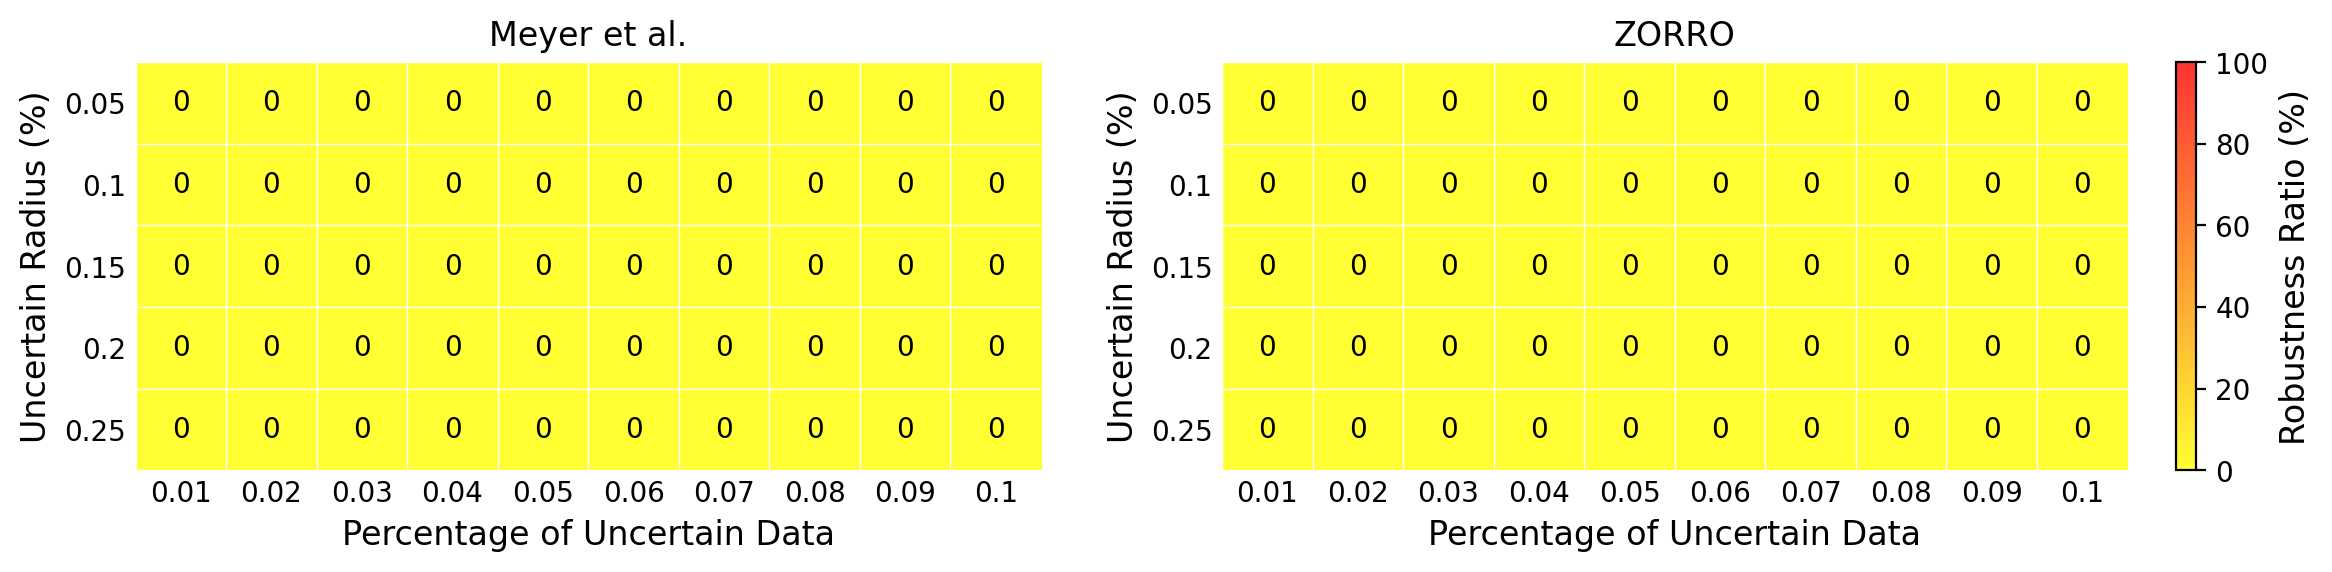

In [21]:
# Heatmaps
df = robustness_interval_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages

# Labels for x-axis and y-axis
x_labels = df.columns.tolist()
y_labels = [0.05, 0.10, 0.15, 0.2, 0.25]

# Create the heatmap plot
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True, dpi=200)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3), dpi=200)
# cmap = plt.get_cmap("coolwarm")
cmap = plt.get_cmap("autumn_r")
heatmap = ax1.imshow(heatmap_data, cmap=cmap, interpolation='nearest', aspect='auto', 
                     alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar = plt.colorbar(heatmap, ax=ax1)
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax1.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax1.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax1.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax1.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax1.set_xticks(np.arange(len(x_labels)))
ax1.set_yticks(np.arange(len(y_labels)))
ax1.set_xticklabels(x_labels)
ax1.set_yticklabels(y_labels)
ax1.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

# Set axis labels
ax1.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax1.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.0f}', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax1.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.1f}', ha='center', va='center', color='black')
ax1.set_title('Meyer et al.')

df = robustness_zonotope_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages
heatmap2 = ax2.imshow(heatmap_data, cmap=cmap, interpolation='nearest', 
                      aspect='auto', alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax2.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax2.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax2.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax2.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax2.set_xticks(np.arange(len(x_labels)))
ax2.set_yticks(np.arange(len(y_labels)))
ax2.set_xticklabels(x_labels)
ax2.set_yticklabels(y_labels)
ax2.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

# Set axis labels
ax2.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax2.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax2.text(j, i, '100', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax2.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax2.text(j, i, f'{np.around(heatmap_data[i][j], 1)}', ha='center', 
                            va='center', color='black')
ax2.set_title('ZORRO')

# fig.suptitle('Robustness Ratio (%)', fontsize=14)
plt.subplots_adjust(wspace=0.2, bottom=0.2, left=0.1, right=0.9)
cb = fig.colorbar(heatmap2, ax=(ax1, ax2), orientation='vertical', pad=0.02)
cb.set_label('Robustness Ratio (%)', fontsize=12)
plt.savefig('ins-linear-rmse-sensitive-heatmap.pdf', bbox_inches='tight')

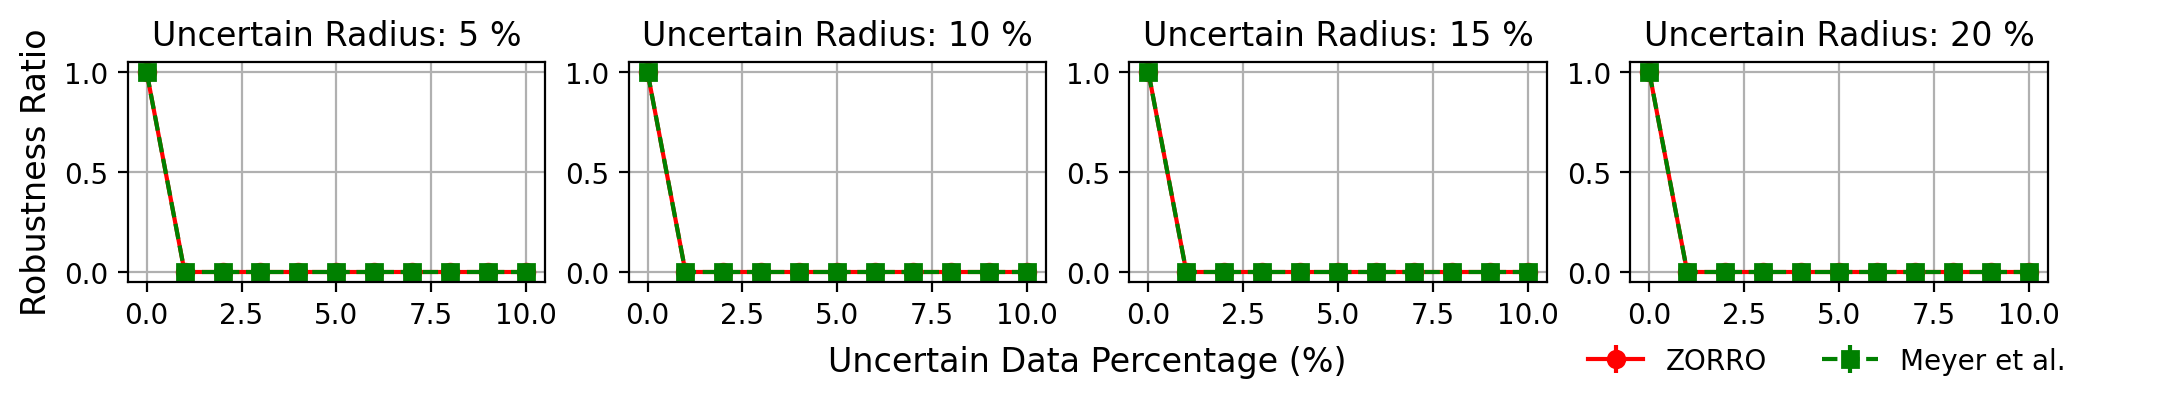

In [22]:
uncertain_pcts = np.array([0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])*100
uncertain_radius_ratios = [0.05, 0.10, 0.15, 0.2, 0.25]

zonotope_data_mean_dict = dict()
zonotope_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    zonotope_data_mean_dict[radius_ratio] = np.append([1], robustness_zonotope_mean.iloc[i, :].to_numpy())
    zonotope_data_std_dict[radius_ratio] = np.append([0], robustness_zonotope_std.iloc[i, :].to_numpy())

interval_data_mean_dict = dict()
interval_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    interval_data_mean_dict[radius_ratio] = np.append([1], robustness_interval_mean.iloc[i, :].to_numpy())
    interval_data_std_dict[radius_ratio] = np.append([0], robustness_interval_std.iloc[i, :].to_numpy())
    
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 2), sharex=True, dpi=200)

for i in range(4):
    uncertain_radius_ratio = uncertain_radius_ratios[i]
    axes[i].errorbar(uncertain_pcts, zonotope_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*zonotope_data_std_dict[uncertain_radius_ratio],
                     marker='o', color='red', label='ZORRO', linestyle='-')
    axes[i].errorbar(uncertain_pcts, interval_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*interval_data_std_dict[uncertain_radius_ratio],
                     marker='s', color='green', label='Meyer et al.', linestyle='--')
    axes[i].set_title(f'Uncertain Radius: {int(uncertain_radius_ratio*100)} %')
    if i == 0:
        axes[i].set_ylabel('Robustness Ratio', fontsize=12)
    axes[i].set_ylim(-0.05, 1.05)
    axes[i].grid(True)

# Adjust layout
lines_labels = [axes[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc = (0.73, 0.03), ncol=2, frameon=False)

plt.subplots_adjust(wspace=0.2, top=0.8, bottom=0.25, left=0.1, right=0.9)
fig.supxlabel('Uncertain Data Percentage (%)', fontsize=12, verticalalignment='bottom')
# plt.tight_layout()
# plt.show()
plt.savefig('ins-linear-rmse-sensitive-labels-lineplot.pdf', bbox_inches='tight')

In [6]:
#Using mae, Ridge
ridge = Ridge(alpha=1.0)
X_train, X_test, y_train, y_test = X_train.reset_index(drop=True) , X_test.reset_index(drop=True) , y_train.reset_index(drop=True) , y_test.reset_index(drop=True)
boundary_indices = leave_one_out(X_train, y_train, X_test, y_test, ridge, mae, maximize=False)
boundary_indices

[556,
 118,
 103,
 550,
 866,
 861,
 405,
 833,
 955,
 739,
 713,
 875,
 431,
 153,
 69,
 229,
 63,
 129,
 24,
 635,
 239,
 1009,
 764,
 1011,
 495,
 357,
 413,
 52,
 146,
 1026,
 974,
 1022,
 907,
 81,
 869,
 825,
 979,
 753,
 769,
 1000,
 485,
 256,
 267,
 104,
 1010,
 744,
 528,
 432,
 525,
 177,
 617,
 673,
 719,
 819,
 754,
 589,
 1036,
 290,
 522,
 332,
 1017,
 977,
 391,
 341,
 816,
 752,
 1028,
 47,
 443,
 675,
 945,
 570,
 694,
 766,
 1016,
 932,
 805,
 881,
 503,
 601,
 246,
 702,
 640,
 351,
 169,
 138,
 88,
 873,
 481,
 46,
 243,
 954,
 912,
 747,
 552,
 28,
 476,
 670,
 202,
 22,
 208,
 599,
 902,
 232,
 953,
 312,
 718,
 494,
 25,
 348,
 612,
 170,
 745,
 920,
 156,
 765,
 331,
 478,
 532,
 144,
 427,
 1065,
 962,
 230,
 961,
 111,
 509,
 306,
 668,
 511,
 460,
 497,
 465,
 4,
 998,
 336,
 292,
 882,
 654,
 307,
 220,
 969,
 134,
 45,
 50,
 289,
 368,
 725,
 211,
 609,
 1047,
 914,
 644,
 172,
 390,
 691,
 1035,
 433,
 854,
 637,
 643,
 147,
 456,
 396,
 684,
 1060,
 667,

In [7]:
robustness_dicts = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 2
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict = dict()
    robustness_dict['uncertain_radius'] = uncertain_radiuses
    robustness_dict['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_dict[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius'):
            #print(uncertain_radius)
            robustness_ratio = compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num,
                                                                    boundary_indices=boundary_indices,
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=False, seed=seed)
            robustness_dict[uncertain_pct].append(robustness_ratio)
    robustness_dicts.append(robustness_dict)

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

In [8]:
robustness_dicts_interval = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 2
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict_interval = dict()
    robustness_dict_interval['uncertain_radius'] = uncertain_radiuses
    robustness_dict_interval['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_dict_interval[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius'):
            robustness_ratio = compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num,
                                                                    boundary_indices=boundary_indices,
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=True, seed=seed)
            robustness_dict_interval[uncertain_pct].append(robustness_ratio)
    robustness_dicts_interval.append(robustness_dict_interval)

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

In [9]:
robustness_interval_mean = sum([pd.DataFrame(robustness_dicts_interval[i]).iloc[:, 2:] for i in range(5)])/5
robustness_interval_std = (sum([(pd.DataFrame(robustness_dicts_interval[i]).iloc[:, 2:]-robustness_interval_mean)**2 for i in range(5)])/5).apply(np.sqrt)
robustness_zonotope_mean = sum([pd.DataFrame(robustness_dicts[i]).iloc[:, 2:] for i in range(5)])/5
robustness_zonotope_std = (sum([(pd.DataFrame(robustness_dicts[i]).iloc[:, 2:]-robustness_zonotope_mean)**2 for i in range(5)])/5).apply(np.sqrt)


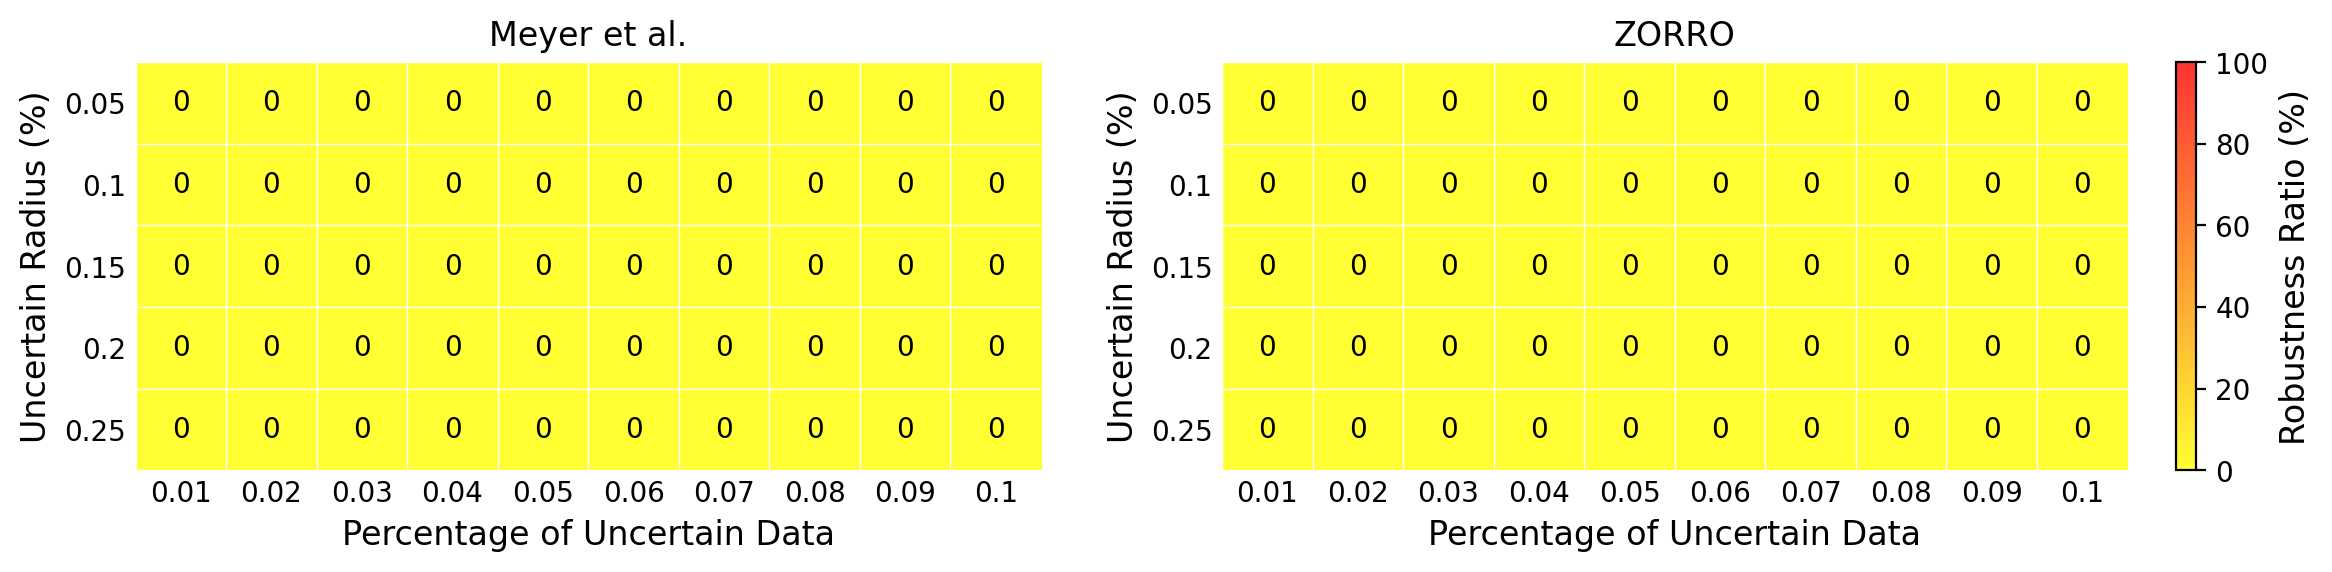

In [10]:
# Heatmaps
df = robustness_interval_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages

# Labels for x-axis and y-axis
x_labels = df.columns.tolist()
y_labels = [0.05, 0.10, 0.15, 0.2, 0.25]

# Create the heatmap plot
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True, dpi=200)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3), dpi=200)
# cmap = plt.get_cmap("coolwarm")
cmap = plt.get_cmap("autumn_r")
heatmap = ax1.imshow(heatmap_data, cmap=cmap, interpolation='nearest', aspect='auto', 
                     alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar = plt.colorbar(heatmap, ax=ax1)
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax1.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax1.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax1.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax1.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax1.set_xticks(np.arange(len(x_labels)))
ax1.set_yticks(np.arange(len(y_labels)))
ax1.set_xticklabels(x_labels)
ax1.set_yticklabels(y_labels)
ax1.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

# Set axis labels
ax1.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax1.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.0f}', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax1.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.1f}', ha='center', va='center', color='black')
ax1.set_title('Meyer et al.')

df = robustness_zonotope_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages
heatmap2 = ax2.imshow(heatmap_data, cmap=cmap, interpolation='nearest', 
                      aspect='auto', alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax2.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax2.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax2.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax2.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax2.set_xticks(np.arange(len(x_labels)))
ax2.set_yticks(np.arange(len(y_labels)))
ax2.set_xticklabels(x_labels)
ax2.set_yticklabels(y_labels)
ax2.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

# Set axis labels
ax2.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax2.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax2.text(j, i, '100', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax2.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax2.text(j, i, f'{np.around(heatmap_data[i][j], 1)}', ha='center', 
                            va='center', color='black')
ax2.set_title('ZORRO')

# fig.suptitle('Robustness Ratio (%)', fontsize=14)
plt.subplots_adjust(wspace=0.2, bottom=0.2, left=0.1, right=0.9)
cb = fig.colorbar(heatmap2, ax=(ax1, ax2), orientation='vertical', pad=0.02)
cb.set_label('Robustness Ratio (%)', fontsize=12)
plt.savefig('ins-ridge-mae-sensitive-heatmap.pdf', bbox_inches='tight')

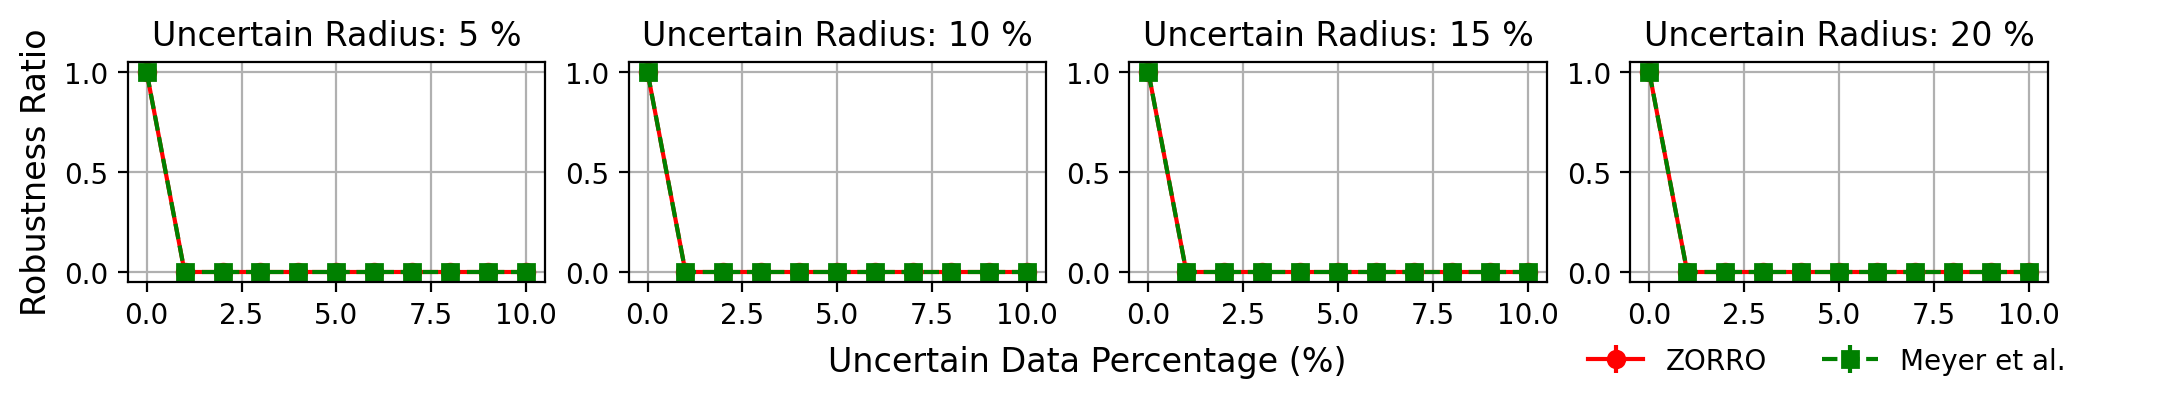

In [11]:
uncertain_pcts = np.array([0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])*100
uncertain_radius_ratios = [0.05, 0.10, 0.15, 0.2, 0.25]

zonotope_data_mean_dict = dict()
zonotope_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    zonotope_data_mean_dict[radius_ratio] = np.append([1], robustness_zonotope_mean.iloc[i, :].to_numpy())
    zonotope_data_std_dict[radius_ratio] = np.append([0], robustness_zonotope_std.iloc[i, :].to_numpy())

interval_data_mean_dict = dict()
interval_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    interval_data_mean_dict[radius_ratio] = np.append([1], robustness_interval_mean.iloc[i, :].to_numpy())
    interval_data_std_dict[radius_ratio] = np.append([0], robustness_interval_std.iloc[i, :].to_numpy())
    
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 2), sharex=True, dpi=200)

for i in range(4):
    uncertain_radius_ratio = uncertain_radius_ratios[i]
    axes[i].errorbar(uncertain_pcts, zonotope_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*zonotope_data_std_dict[uncertain_radius_ratio],
                     marker='o', color='red', label='ZORRO', linestyle='-')
    axes[i].errorbar(uncertain_pcts, interval_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*interval_data_std_dict[uncertain_radius_ratio],
                     marker='s', color='green', label='Meyer et al.', linestyle='--')
    axes[i].set_title(f'Uncertain Radius: {int(uncertain_radius_ratio*100)} %')
    if i == 0:
        axes[i].set_ylabel('Robustness Ratio', fontsize=12)
    axes[i].set_ylim(-0.05, 1.05)
    axes[i].grid(True)

# Adjust layout
lines_labels = [axes[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc = (0.73, 0.03), ncol=2, frameon=False)

plt.subplots_adjust(wspace=0.2, top=0.8, bottom=0.25, left=0.1, right=0.9)
fig.supxlabel('Uncertain Data Percentage (%)', fontsize=12, verticalalignment='bottom')
# plt.tight_layout()
# plt.show()
plt.savefig('ins-ridge-mae-sensitive-labels-lineplot.pdf', bbox_inches='tight')

In [12]:
#Using r2, Ridge
ridge = Ridge(alpha=1.0)
X_train, X_test, y_train, y_test = X_train.reset_index(drop=True) , X_test.reset_index(drop=True) , y_train.reset_index(drop=True) , y_test.reset_index(drop=True)
boundary_indices = leave_one_out(X_train, y_train, X_test, y_test, ridge, r_squared)
boundary_indices

[404,
 1020,
 392,
 182,
 196,
 194,
 346,
 1004,
 1019,
 822,
 692,
 273,
 1034,
 545,
 886,
 271,
 860,
 983,
 949,
 811,
 378,
 241,
 394,
 496,
 29,
 581,
 467,
 600,
 123,
 663,
 77,
 425,
 959,
 689,
 285,
 908,
 414,
 98,
 1067,
 115,
 676,
 770,
 508,
 524,
 187,
 1050,
 935,
 927,
 547,
 296,
 611,
 205,
 356,
 915,
 842,
 785,
 555,
 826,
 1062,
 475,
 634,
 738,
 850,
 470,
 380,
 492,
 85,
 411,
 415,
 783,
 326,
 957,
 515,
 823,
 490,
 506,
 830,
 375,
 66,
 484,
 565,
 961,
 509,
 668,
 306,
 546,
 74,
 1025,
 134,
 745,
 403,
 965,
 290,
 497,
 339,
 879,
 819,
 865,
 684,
 557,
 25,
 1065,
 902,
 536,
 517,
 177,
 747,
 224,
 946,
 173,
 755,
 172,
 319,
 502,
 292,
 227,
 433,
 558,
 854,
 22,
 937,
 691,
 837,
 670,
 0,
 1014,
 601,
 331,
 768,
 703,
 88,
 186,
 816,
 430,
 678,
 805,
 487,
 599,
 111,
 46,
 38,
 213,
 249,
 336,
 1036,
 591,
 268,
 215,
 1013,
 520,
 977,
 867,
 246,
 312,
 462,
 437,
 722,
 694,
 426,
 211,
 222,
 766,
 821,
 422,
 237,
 680,
 519,

In [13]:
robustness_dicts = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 2
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict = dict()
    robustness_dict['uncertain_radius'] = uncertain_radiuses
    robustness_dict['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_dict[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius'):
            #print(uncertain_radius)
            robustness_ratio = compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num,
                                                                    boundary_indices=boundary_indices,
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=False, seed=seed)
            robustness_dict[uncertain_pct].append(robustness_ratio)
    robustness_dicts.append(robustness_dict)

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

In [14]:
robustness_dicts_interval = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 2
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict_interval = dict()
    robustness_dict_interval['uncertain_radius'] = uncertain_radiuses
    robustness_dict_interval['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_dict_interval[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius'):
            robustness_ratio = compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num,
                                                                    boundary_indices=boundary_indices,
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=True, seed=seed)
            robustness_dict_interval[uncertain_pct].append(robustness_ratio)
    robustness_dicts_interval.append(robustness_dict_interval)

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

In [15]:
robustness_interval_mean = sum([pd.DataFrame(robustness_dicts_interval[i]).iloc[:, 2:] for i in range(5)])/5
robustness_interval_std = (sum([(pd.DataFrame(robustness_dicts_interval[i]).iloc[:, 2:]-robustness_interval_mean)**2 for i in range(5)])/5).apply(np.sqrt)
robustness_zonotope_mean = sum([pd.DataFrame(robustness_dicts[i]).iloc[:, 2:] for i in range(5)])/5
robustness_zonotope_std = (sum([(pd.DataFrame(robustness_dicts[i]).iloc[:, 2:]-robustness_zonotope_mean)**2 for i in range(5)])/5).apply(np.sqrt)


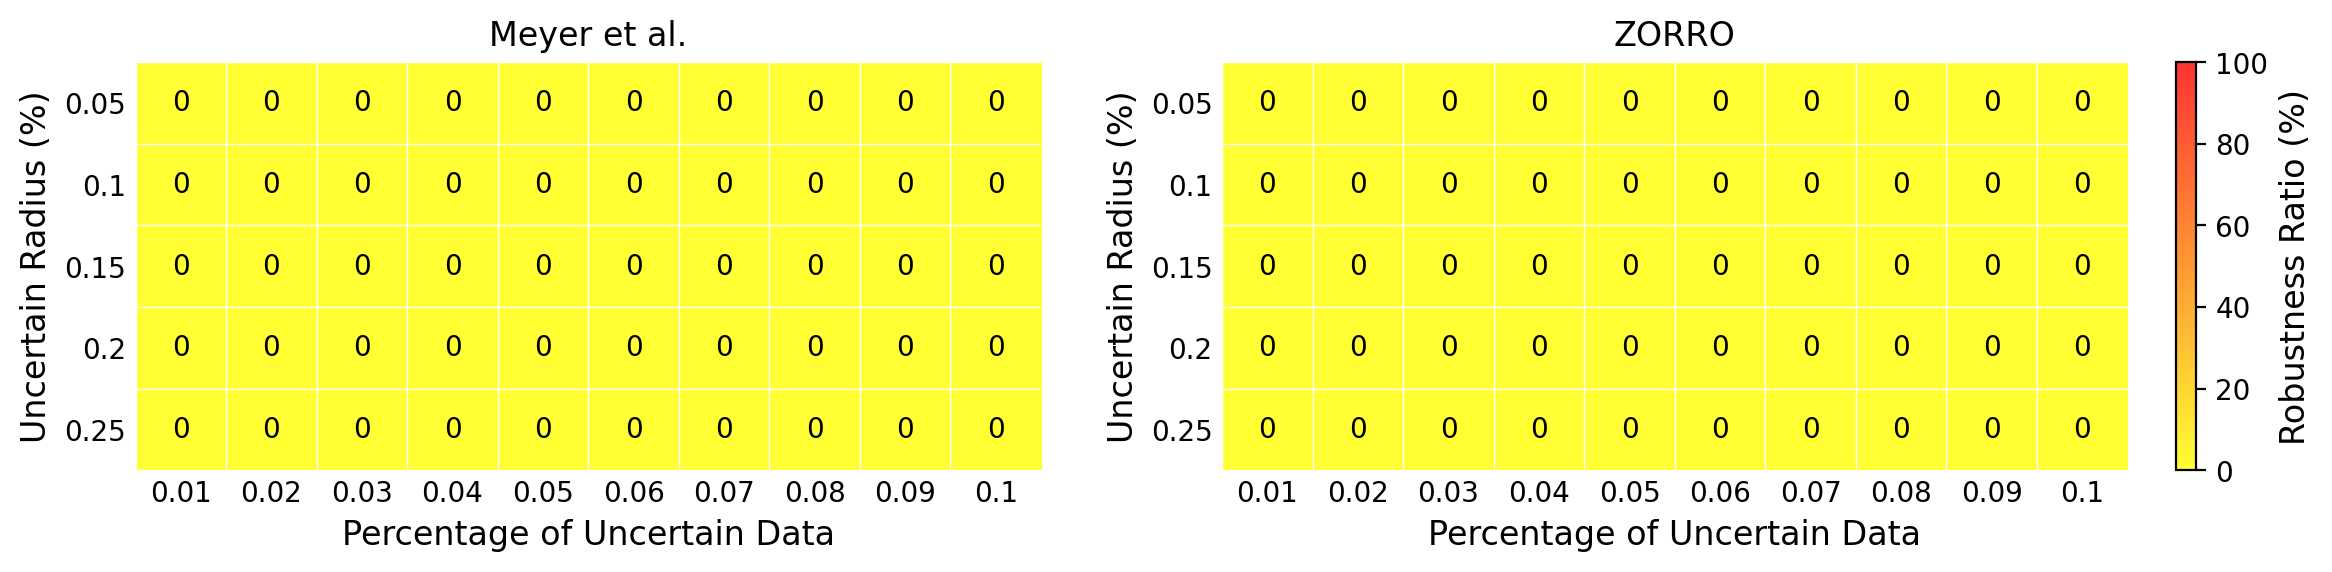

In [16]:
# Heatmaps
df = robustness_interval_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages

# Labels for x-axis and y-axis
x_labels = df.columns.tolist()
y_labels = [0.05, 0.10, 0.15, 0.2, 0.25]

# Create the heatmap plot
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True, dpi=200)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3), dpi=200)
# cmap = plt.get_cmap("coolwarm")
cmap = plt.get_cmap("autumn_r")
heatmap = ax1.imshow(heatmap_data, cmap=cmap, interpolation='nearest', aspect='auto', 
                     alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar = plt.colorbar(heatmap, ax=ax1)
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax1.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax1.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax1.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax1.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax1.set_xticks(np.arange(len(x_labels)))
ax1.set_yticks(np.arange(len(y_labels)))
ax1.set_xticklabels(x_labels)
ax1.set_yticklabels(y_labels)
ax1.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

# Set axis labels
ax1.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax1.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.0f}', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax1.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.1f}', ha='center', va='center', color='black')
ax1.set_title('Meyer et al.')

df = robustness_zonotope_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages
heatmap2 = ax2.imshow(heatmap_data, cmap=cmap, interpolation='nearest', 
                      aspect='auto', alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax2.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax2.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax2.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax2.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax2.set_xticks(np.arange(len(x_labels)))
ax2.set_yticks(np.arange(len(y_labels)))
ax2.set_xticklabels(x_labels)
ax2.set_yticklabels(y_labels)
ax2.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

# Set axis labels
ax2.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax2.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax2.text(j, i, '100', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax2.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax2.text(j, i, f'{np.around(heatmap_data[i][j], 1)}', ha='center', 
                            va='center', color='black')
ax2.set_title('ZORRO')

# fig.suptitle('Robustness Ratio (%)', fontsize=14)
plt.subplots_adjust(wspace=0.2, bottom=0.2, left=0.1, right=0.9)
cb = fig.colorbar(heatmap2, ax=(ax1, ax2), orientation='vertical', pad=0.02)
cb.set_label('Robustness Ratio (%)', fontsize=12)
plt.savefig('ins-ridge-r2-sensitive-heatmap.pdf', bbox_inches='tight')

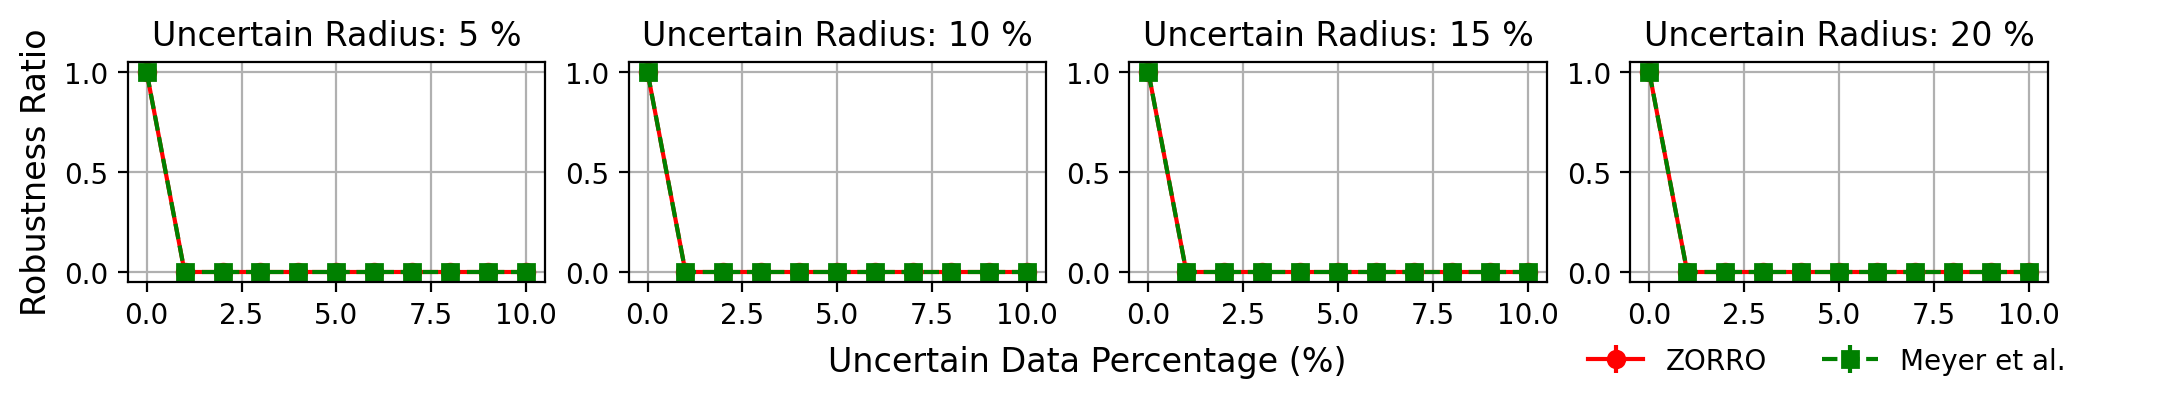

In [17]:
uncertain_pcts = np.array([0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])*100
uncertain_radius_ratios = [0.05, 0.10, 0.15, 0.2, 0.25]

zonotope_data_mean_dict = dict()
zonotope_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    zonotope_data_mean_dict[radius_ratio] = np.append([1], robustness_zonotope_mean.iloc[i, :].to_numpy())
    zonotope_data_std_dict[radius_ratio] = np.append([0], robustness_zonotope_std.iloc[i, :].to_numpy())

interval_data_mean_dict = dict()
interval_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    interval_data_mean_dict[radius_ratio] = np.append([1], robustness_interval_mean.iloc[i, :].to_numpy())
    interval_data_std_dict[radius_ratio] = np.append([0], robustness_interval_std.iloc[i, :].to_numpy())
    
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 2), sharex=True, dpi=200)

for i in range(4):
    uncertain_radius_ratio = uncertain_radius_ratios[i]
    axes[i].errorbar(uncertain_pcts, zonotope_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*zonotope_data_std_dict[uncertain_radius_ratio],
                     marker='o', color='red', label='ZORRO', linestyle='-')
    axes[i].errorbar(uncertain_pcts, interval_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*interval_data_std_dict[uncertain_radius_ratio],
                     marker='s', color='green', label='Meyer et al.', linestyle='--')
    axes[i].set_title(f'Uncertain Radius: {int(uncertain_radius_ratio*100)} %')
    if i == 0:
        axes[i].set_ylabel('Robustness Ratio', fontsize=12)
    axes[i].set_ylim(-0.05, 1.05)
    axes[i].grid(True)

# Adjust layout
lines_labels = [axes[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc = (0.73, 0.03), ncol=2, frameon=False)

plt.subplots_adjust(wspace=0.2, top=0.8, bottom=0.25, left=0.1, right=0.9)
fig.supxlabel('Uncertain Data Percentage (%)', fontsize=12, verticalalignment='bottom')
# plt.tight_layout()
# plt.show()
plt.savefig('ins-ridge-r2-sensitive-labels-lineplot.pdf', bbox_inches='tight')

In [18]:
#Using mse, Ridge
ridge = Ridge(alpha=1.0)
X_train, X_test, y_train, y_test = X_train.reset_index(drop=True) , X_test.reset_index(drop=True) , y_train.reset_index(drop=True) , y_test.reset_index(drop=True)
boundary_indices = leave_one_out(X_train, y_train, X_test, y_test, ridge, mse, maximize=False)
boundary_indices

[404,
 1020,
 392,
 182,
 196,
 194,
 346,
 1004,
 1019,
 822,
 692,
 273,
 1034,
 545,
 886,
 271,
 860,
 983,
 949,
 811,
 378,
 241,
 394,
 496,
 29,
 581,
 467,
 600,
 123,
 663,
 77,
 425,
 959,
 689,
 285,
 908,
 414,
 98,
 1067,
 115,
 676,
 770,
 508,
 524,
 187,
 1050,
 935,
 927,
 547,
 296,
 611,
 205,
 356,
 915,
 842,
 785,
 555,
 826,
 1062,
 475,
 634,
 738,
 850,
 470,
 380,
 492,
 85,
 411,
 415,
 783,
 326,
 957,
 515,
 823,
 490,
 506,
 830,
 375,
 66,
 484,
 565,
 961,
 509,
 668,
 306,
 546,
 74,
 1025,
 134,
 745,
 403,
 965,
 290,
 497,
 339,
 879,
 819,
 865,
 684,
 557,
 25,
 1065,
 902,
 536,
 517,
 177,
 747,
 224,
 946,
 173,
 755,
 172,
 319,
 502,
 292,
 227,
 433,
 558,
 854,
 22,
 937,
 691,
 837,
 670,
 0,
 1014,
 601,
 331,
 768,
 703,
 88,
 186,
 816,
 430,
 678,
 805,
 487,
 599,
 111,
 46,
 38,
 213,
 249,
 336,
 1036,
 591,
 268,
 215,
 1013,
 520,
 977,
 867,
 246,
 312,
 462,
 437,
 722,
 694,
 426,
 211,
 222,
 766,
 821,
 422,
 237,
 680,
 519,

In [19]:
robustness_dicts = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 2
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict = dict()
    robustness_dict['uncertain_radius'] = uncertain_radiuses
    robustness_dict['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_dict[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius'):
            #print(uncertain_radius)
            robustness_ratio = compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num,
                                                                    boundary_indices=boundary_indices,
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=False, seed=seed)
            robustness_dict[uncertain_pct].append(robustness_ratio)
    robustness_dicts.append(robustness_dict)

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

In [20]:
robustness_dicts_interval = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 2
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict_interval = dict()
    robustness_dict_interval['uncertain_radius'] = uncertain_radiuses
    robustness_dict_interval['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_dict_interval[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius'):
            robustness_ratio = compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num,
                                                                    boundary_indices=boundary_indices,
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=True, seed=seed)
            robustness_dict_interval[uncertain_pct].append(robustness_ratio)
    robustness_dicts_interval.append(robustness_dict_interval)

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

In [21]:
robustness_interval_mean = sum([pd.DataFrame(robustness_dicts_interval[i]).iloc[:, 2:] for i in range(5)])/5
robustness_interval_std = (sum([(pd.DataFrame(robustness_dicts_interval[i]).iloc[:, 2:]-robustness_interval_mean)**2 for i in range(5)])/5).apply(np.sqrt)
robustness_zonotope_mean = sum([pd.DataFrame(robustness_dicts[i]).iloc[:, 2:] for i in range(5)])/5
robustness_zonotope_std = (sum([(pd.DataFrame(robustness_dicts[i]).iloc[:, 2:]-robustness_zonotope_mean)**2 for i in range(5)])/5).apply(np.sqrt)


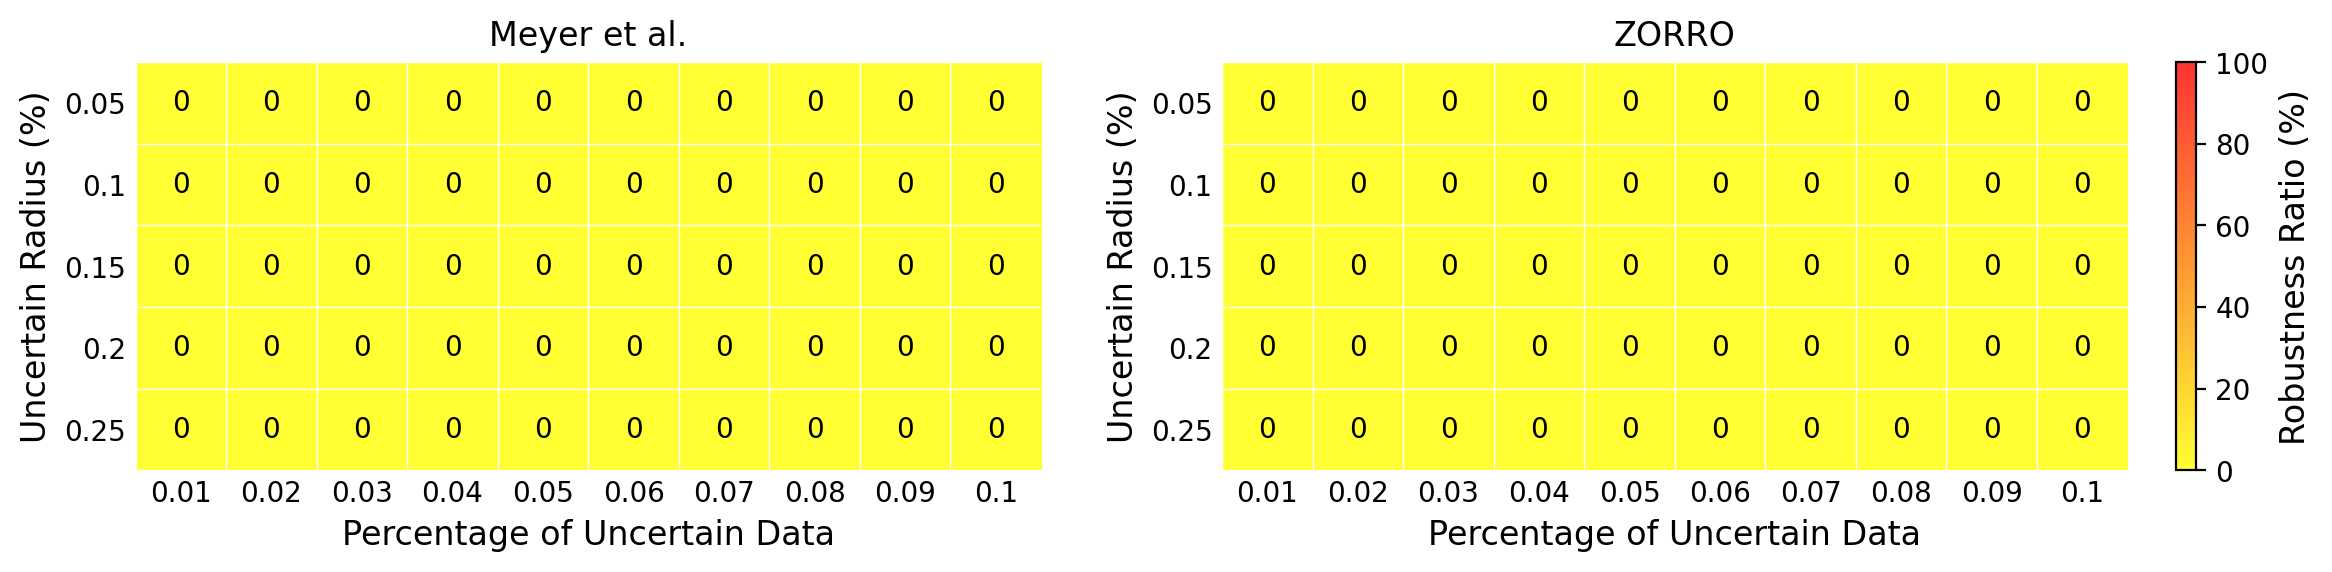

In [22]:
# Heatmaps
df = robustness_interval_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages

# Labels for x-axis and y-axis
x_labels = df.columns.tolist()
y_labels = [0.05, 0.10, 0.15, 0.2, 0.25]

# Create the heatmap plot
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True, dpi=200)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3), dpi=200)
# cmap = plt.get_cmap("coolwarm")
cmap = plt.get_cmap("autumn_r")
heatmap = ax1.imshow(heatmap_data, cmap=cmap, interpolation='nearest', aspect='auto', 
                     alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar = plt.colorbar(heatmap, ax=ax1)
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax1.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax1.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax1.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax1.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax1.set_xticks(np.arange(len(x_labels)))
ax1.set_yticks(np.arange(len(y_labels)))
ax1.set_xticklabels(x_labels)
ax1.set_yticklabels(y_labels)
ax1.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

# Set axis labels
ax1.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax1.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.0f}', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax1.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.1f}', ha='center', va='center', color='black')
ax1.set_title('Meyer et al.')

df = robustness_zonotope_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages
heatmap2 = ax2.imshow(heatmap_data, cmap=cmap, interpolation='nearest', 
                      aspect='auto', alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax2.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax2.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax2.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax2.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax2.set_xticks(np.arange(len(x_labels)))
ax2.set_yticks(np.arange(len(y_labels)))
ax2.set_xticklabels(x_labels)
ax2.set_yticklabels(y_labels)
ax2.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

# Set axis labels
ax2.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax2.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax2.text(j, i, '100', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax2.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax2.text(j, i, f'{np.around(heatmap_data[i][j], 1)}', ha='center', 
                            va='center', color='black')
ax2.set_title('ZORRO')

# fig.suptitle('Robustness Ratio (%)', fontsize=14)
plt.subplots_adjust(wspace=0.2, bottom=0.2, left=0.1, right=0.9)
cb = fig.colorbar(heatmap2, ax=(ax1, ax2), orientation='vertical', pad=0.02)
cb.set_label('Robustness Ratio (%)', fontsize=12)
plt.savefig('ins-ridge-mse-sensitive-heatmap.pdf', bbox_inches='tight')

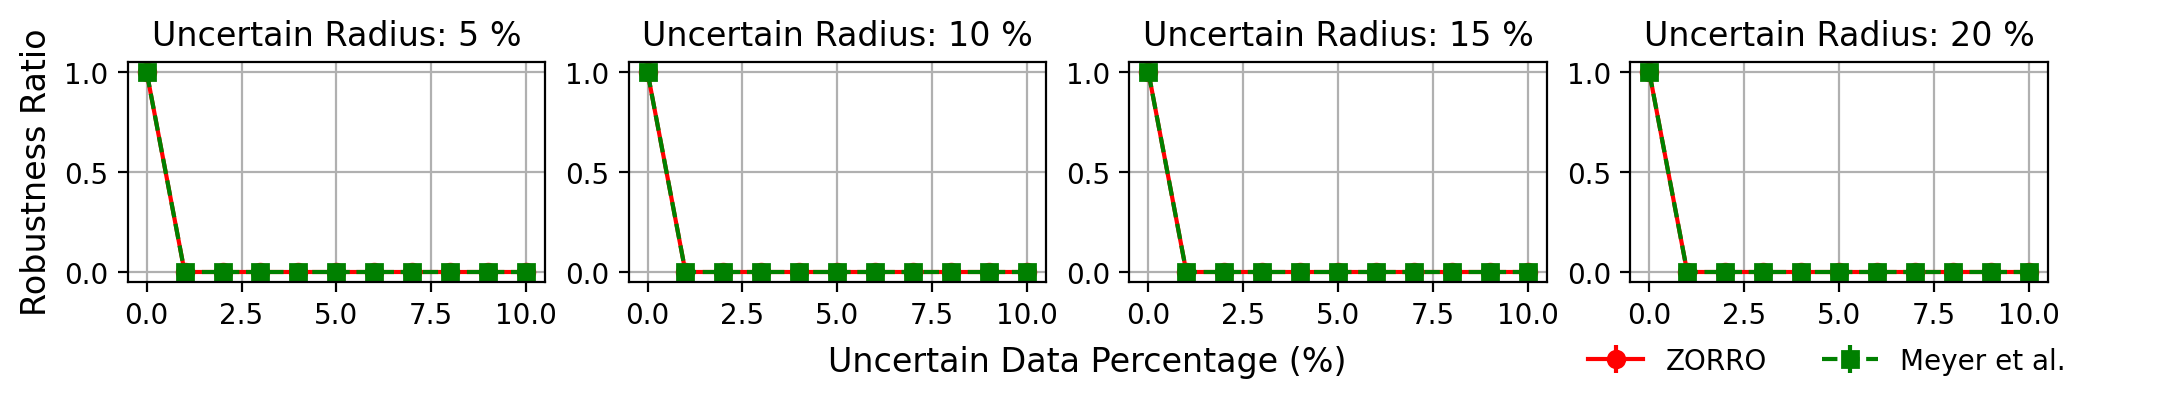

In [23]:
uncertain_pcts = np.array([0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])*100
uncertain_radius_ratios = [0.05, 0.10, 0.15, 0.2, 0.25]

zonotope_data_mean_dict = dict()
zonotope_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    zonotope_data_mean_dict[radius_ratio] = np.append([1], robustness_zonotope_mean.iloc[i, :].to_numpy())
    zonotope_data_std_dict[radius_ratio] = np.append([0], robustness_zonotope_std.iloc[i, :].to_numpy())

interval_data_mean_dict = dict()
interval_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    interval_data_mean_dict[radius_ratio] = np.append([1], robustness_interval_mean.iloc[i, :].to_numpy())
    interval_data_std_dict[radius_ratio] = np.append([0], robustness_interval_std.iloc[i, :].to_numpy())
    
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 2), sharex=True, dpi=200)

for i in range(4):
    uncertain_radius_ratio = uncertain_radius_ratios[i]
    axes[i].errorbar(uncertain_pcts, zonotope_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*zonotope_data_std_dict[uncertain_radius_ratio],
                     marker='o', color='red', label='ZORRO', linestyle='-')
    axes[i].errorbar(uncertain_pcts, interval_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*interval_data_std_dict[uncertain_radius_ratio],
                     marker='s', color='green', label='Meyer et al.', linestyle='--')
    axes[i].set_title(f'Uncertain Radius: {int(uncertain_radius_ratio*100)} %')
    if i == 0:
        axes[i].set_ylabel('Robustness Ratio', fontsize=12)
    axes[i].set_ylim(-0.05, 1.05)
    axes[i].grid(True)

# Adjust layout
lines_labels = [axes[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc = (0.73, 0.03), ncol=2, frameon=False)

plt.subplots_adjust(wspace=0.2, top=0.8, bottom=0.25, left=0.1, right=0.9)
fig.supxlabel('Uncertain Data Percentage (%)', fontsize=12, verticalalignment='bottom')
# plt.tight_layout()
# plt.show()
plt.savefig('ins-ridge-mse-sensitive-labels-lineplot.pdf', bbox_inches='tight')

In [24]:
#Using rmse, Ridge
ridge = Ridge(alpha=1.0)
X_train, X_test, y_train, y_test = X_train.reset_index(drop=True) , X_test.reset_index(drop=True) , y_train.reset_index(drop=True) , y_test.reset_index(drop=True)
boundary_indices = leave_one_out(X_train, y_train, X_test, y_test, ridge, rmse, maximize=False)
boundary_indices

[404,
 1020,
 392,
 182,
 196,
 194,
 346,
 1004,
 1019,
 822,
 692,
 273,
 1034,
 545,
 886,
 271,
 860,
 983,
 949,
 811,
 378,
 241,
 394,
 496,
 29,
 581,
 467,
 600,
 123,
 663,
 77,
 425,
 959,
 689,
 285,
 908,
 414,
 98,
 1067,
 115,
 676,
 770,
 508,
 524,
 187,
 1050,
 935,
 927,
 547,
 296,
 611,
 205,
 356,
 915,
 842,
 785,
 555,
 826,
 1062,
 475,
 634,
 738,
 850,
 470,
 380,
 492,
 85,
 411,
 415,
 783,
 326,
 957,
 515,
 823,
 490,
 506,
 830,
 375,
 66,
 484,
 565,
 961,
 509,
 668,
 306,
 546,
 74,
 1025,
 134,
 745,
 403,
 965,
 290,
 497,
 339,
 879,
 819,
 865,
 684,
 557,
 25,
 1065,
 902,
 536,
 517,
 177,
 747,
 224,
 946,
 173,
 755,
 172,
 319,
 502,
 292,
 227,
 433,
 558,
 854,
 22,
 937,
 691,
 837,
 670,
 0,
 1014,
 601,
 331,
 768,
 703,
 88,
 186,
 816,
 430,
 678,
 805,
 487,
 599,
 111,
 46,
 38,
 213,
 249,
 336,
 1036,
 591,
 268,
 215,
 1013,
 520,
 977,
 867,
 246,
 312,
 462,
 437,
 722,
 694,
 426,
 211,
 222,
 766,
 821,
 422,
 237,
 680,
 519,

In [25]:
robustness_dicts = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 2
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict = dict()
    robustness_dict['uncertain_radius'] = uncertain_radiuses
    robustness_dict['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_dict[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius'):
            #print(uncertain_radius)
            robustness_ratio = compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num,
                                                                    boundary_indices=boundary_indices,
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=False, seed=seed)
            robustness_dict[uncertain_pct].append(robustness_ratio)
    robustness_dicts.append(robustness_dict)

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

In [26]:
robustness_dicts_interval = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 2
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict_interval = dict()
    robustness_dict_interval['uncertain_radius'] = uncertain_radiuses
    robustness_dict_interval['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_dict_interval[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius'):
            robustness_ratio = compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num,
                                                                    boundary_indices=boundary_indices,
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=True, seed=seed)
            robustness_dict_interval[uncertain_pct].append(robustness_ratio)
    robustness_dicts_interval.append(robustness_dict_interval)

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

In [27]:
robustness_interval_mean = sum([pd.DataFrame(robustness_dicts_interval[i]).iloc[:, 2:] for i in range(5)])/5
robustness_interval_std = (sum([(pd.DataFrame(robustness_dicts_interval[i]).iloc[:, 2:]-robustness_interval_mean)**2 for i in range(5)])/5).apply(np.sqrt)
robustness_zonotope_mean = sum([pd.DataFrame(robustness_dicts[i]).iloc[:, 2:] for i in range(5)])/5
robustness_zonotope_std = (sum([(pd.DataFrame(robustness_dicts[i]).iloc[:, 2:]-robustness_zonotope_mean)**2 for i in range(5)])/5).apply(np.sqrt)


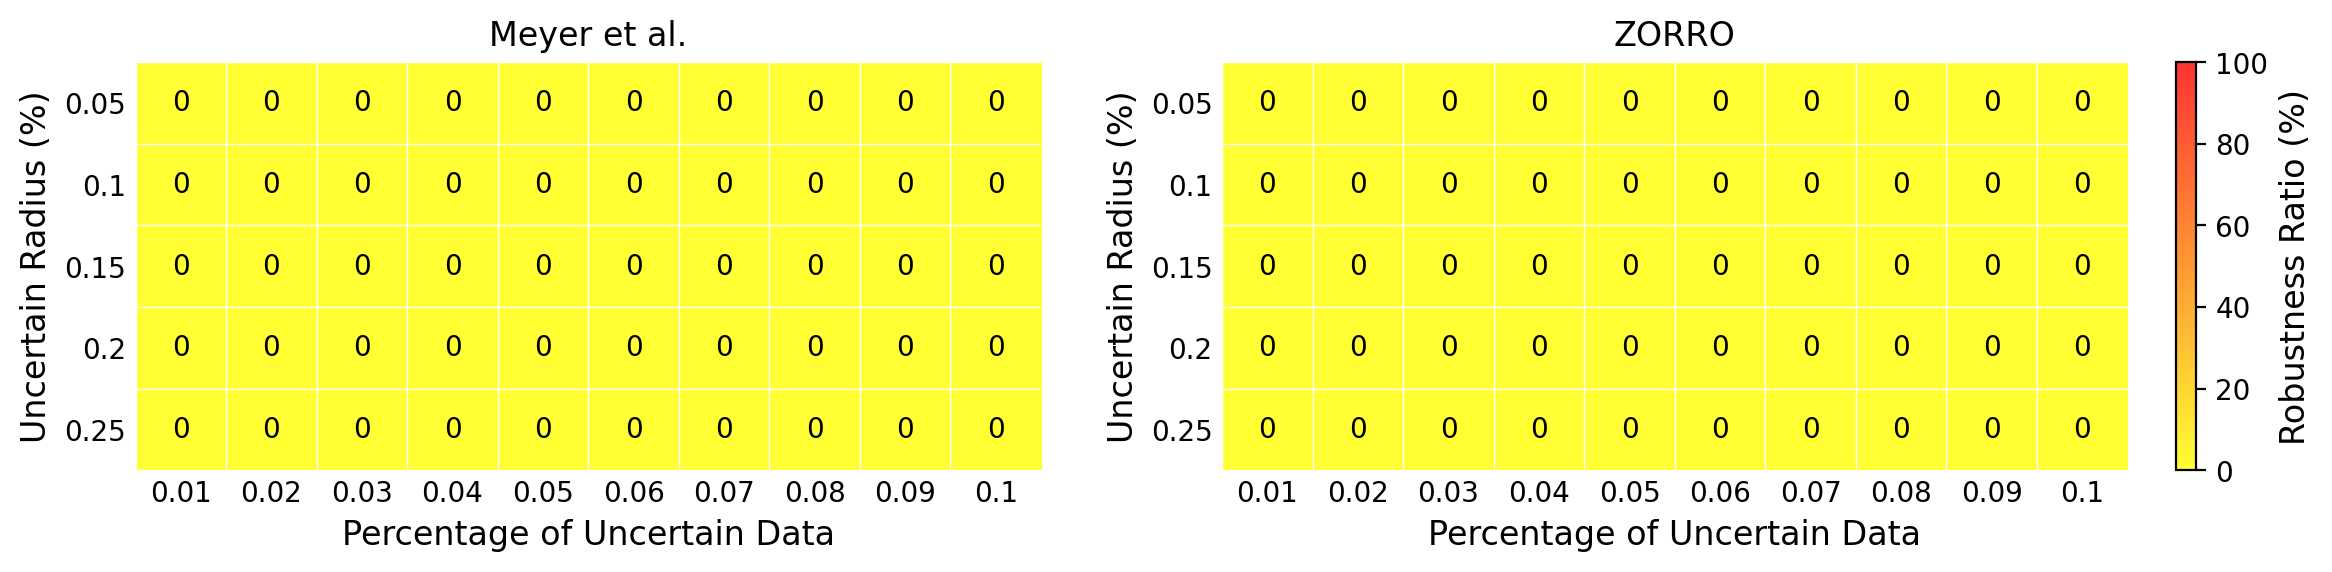

In [28]:
# Heatmaps
df = robustness_interval_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages

# Labels for x-axis and y-axis
x_labels = df.columns.tolist()
y_labels = [0.05, 0.10, 0.15, 0.2, 0.25]

# Create the heatmap plot
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True, dpi=200)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3), dpi=200)
# cmap = plt.get_cmap("coolwarm")
cmap = plt.get_cmap("autumn_r")
heatmap = ax1.imshow(heatmap_data, cmap=cmap, interpolation='nearest', aspect='auto', 
                     alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar = plt.colorbar(heatmap, ax=ax1)
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax1.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax1.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax1.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax1.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax1.set_xticks(np.arange(len(x_labels)))
ax1.set_yticks(np.arange(len(y_labels)))
ax1.set_xticklabels(x_labels)
ax1.set_yticklabels(y_labels)
ax1.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

# Set axis labels
ax1.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax1.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.0f}', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax1.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.1f}', ha='center', va='center', color='black')
ax1.set_title('Meyer et al.')

df = robustness_zonotope_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages
heatmap2 = ax2.imshow(heatmap_data, cmap=cmap, interpolation='nearest', 
                      aspect='auto', alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax2.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax2.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax2.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax2.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax2.set_xticks(np.arange(len(x_labels)))
ax2.set_yticks(np.arange(len(y_labels)))
ax2.set_xticklabels(x_labels)
ax2.set_yticklabels(y_labels)
ax2.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

# Set axis labels
ax2.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax2.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax2.text(j, i, '100', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax2.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax2.text(j, i, f'{np.around(heatmap_data[i][j], 1)}', ha='center', 
                            va='center', color='black')
ax2.set_title('ZORRO')

# fig.suptitle('Robustness Ratio (%)', fontsize=14)
plt.subplots_adjust(wspace=0.2, bottom=0.2, left=0.1, right=0.9)
cb = fig.colorbar(heatmap2, ax=(ax1, ax2), orientation='vertical', pad=0.02)
cb.set_label('Robustness Ratio (%)', fontsize=12)
plt.savefig('ins-ridge-rmse-sensitive-heatmap.pdf', bbox_inches='tight')

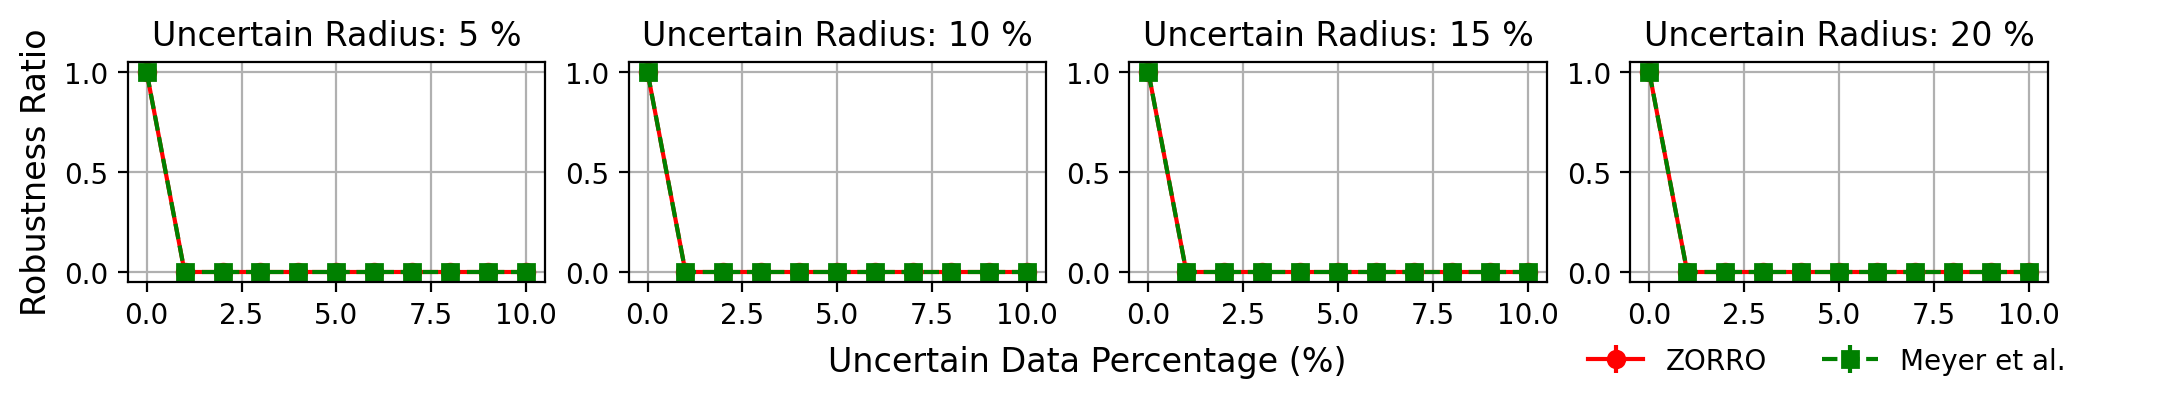

In [29]:
uncertain_pcts = np.array([0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])*100
uncertain_radius_ratios = [0.05, 0.10, 0.15, 0.2, 0.25]

zonotope_data_mean_dict = dict()
zonotope_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    zonotope_data_mean_dict[radius_ratio] = np.append([1], robustness_zonotope_mean.iloc[i, :].to_numpy())
    zonotope_data_std_dict[radius_ratio] = np.append([0], robustness_zonotope_std.iloc[i, :].to_numpy())

interval_data_mean_dict = dict()
interval_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    interval_data_mean_dict[radius_ratio] = np.append([1], robustness_interval_mean.iloc[i, :].to_numpy())
    interval_data_std_dict[radius_ratio] = np.append([0], robustness_interval_std.iloc[i, :].to_numpy())
    
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 2), sharex=True, dpi=200)

for i in range(4):
    uncertain_radius_ratio = uncertain_radius_ratios[i]
    axes[i].errorbar(uncertain_pcts, zonotope_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*zonotope_data_std_dict[uncertain_radius_ratio],
                     marker='o', color='red', label='ZORRO', linestyle='-')
    axes[i].errorbar(uncertain_pcts, interval_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*interval_data_std_dict[uncertain_radius_ratio],
                     marker='s', color='green', label='Meyer et al.', linestyle='--')
    axes[i].set_title(f'Uncertain Radius: {int(uncertain_radius_ratio*100)} %')
    if i == 0:
        axes[i].set_ylabel('Robustness Ratio', fontsize=12)
    axes[i].set_ylim(-0.05, 1.05)
    axes[i].grid(True)

# Adjust layout
lines_labels = [axes[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc = (0.73, 0.03), ncol=2, frameon=False)

plt.subplots_adjust(wspace=0.2, top=0.8, bottom=0.25, left=0.1, right=0.9)
fig.supxlabel('Uncertain Data Percentage (%)', fontsize=12, verticalalignment='bottom')
# plt.tight_layout()
# plt.show()
plt.savefig('ins-ridge-rmse-sensitive-labels-lineplot.pdf', bbox_inches='tight')